In [1]:
#!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
#!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
#!pip install torch-geometric #to install Python-Geometric (pyg)!
# pip install torch-sparse
#!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.13.1+cu116.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-1.13.1+cu116.html
# !pip install torch-geometric

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as pyg
import torch_geometric
from   torch.utils.data      import Dataset, DataLoader
from   torch_geometric.data  import Data
from   torch_geometric.utils import negative_sampling
import matplotlib.pyplot as plt #needed to visualize loss curves
import numpy as np 
import os 
from tqdm.notebook   import tqdm
from sklearn.metrics import accuracy_score
from sklearn         import metrics
from sklearn.metrics import ConfusionMatrixDisplay
import pandas as pd

import networkx as nx


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.__version__)



cuda
1.13.1+cu116


In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Introduction 
In recent years, Natural Language Processing (NLP) has been revolutionized by transformer-based Large Language Models (LLMs) [1]. As a precedent,  BERT [2] led to a state-of-the-art performance in multiple downstream tasks, out-competing specialized systems at that time [3]. However, the increase in the performance of LLMs comes at the price of training on large data sets, managing costly infrastructure, and leveraging immense computing resources  [4]. This impact has also been translated to the biology domain, as an example [5] introduced ProteinBERT, a deep language model specifically designed for proteins. The pretraining scheme combines language modeling with a novel task of Gene Ontology (GO) annotation prediction which provides novel architectural elements that make the model highly efficient and flexible to  long sequences. 



[Talk about GNNS] 



In this work, we introduce two algorithms **BERT2SAGE** and **BERT2MULT**. We combined the expressiveness of LLMs (ProteinBERT) and Graph Neural  Networks in order to predict Protein to Protein Interaction (PPI). Furthermore, we compare the performance of ProteinBERT (+ Projection Head for PPI) against BERT2SAGE and BERT2MULT. We show that Graph LLM-based algorithms outperform plain LLM algorithms. Showing that LLM can be good feature extractors for GNN's

BERT2SAGE:

BERT2MULT:


## Steps

#### Step 1:  DATASET
First, we will use ProteinBERT [5] to encode proteins into a fixed-size low-dimensional embedding space based on their sequence. To train this model, the protein sequences were encoded as sequences of integer tokens, and ProteinBERT was trained to create a 1024-dimensional embedding given the input sequence. This model can be used to obtain protein representation sequences from any biological species (inductive). Thus given the protein sequences, we can use the pre-trained ProteinBERT model to define the initial node properties for a given organism.



For this task, we will use a subset of the STRING dataset [6], the ogbl-ppa dataset [7], which contains
precomputed functional links between proteins (inferred from genomic associations). The STRING
dataset provides a graphical representation of the network of inferred, weighted PPIs (high-level view
of functional linkage), facilitating the analysis of modularity in biological processes. It is estimated
that the database predicts functional interactions at an average accuracy of at least 80% for more than
half of the genes. Furthermore, STRING is updated continuously, and currently contains 261,033
orthologs in 89 fully sequenced genomes.

#### Step 2: Training   GraphSage embeddings
GraphSAGE is a general inductive framework that leverages node feature
information to efficiently generate node embeddings for
previously unseen data. Instead of training individual embeddings for each node, GraphSAGE
 learns a function that generates embeddings by sampling and aggregating features
from a node’s local neighborhood. Thus We will use GraphSage (with ProteinBert Embeddigns as our Inital Node embeddigns $h_v^0$) to fine tune the node represeantion for PPI

#### Step 3 : Multi-Layer Perceptron Head

Once We have robust and expressive embeddings for PPI We (jointly) train a simple Multilayer Preceptron to predict if two proteins interact or not 



### TASK:
Given nodes $v_i \in V_j$ which represent proteins from a species we want to use bert2sage to predict \emph{a priori} the edges $E_i$ in order to construct a graph $G_j(V_j, E_j)$ that indicates protein-protein interactions (PPIs) from a previously uncharacterized species.


### SETUP:
Setup: Assume we have  M graphs denoted as: $[G_1 ,G_2,.. G_M ]  $  $  ,  G_j(V_j,E_j)$:
* $V_j$ is the vertex set (all vertex nodes in a graph)
*  $E_J$ is the edge set (all linkins in a graph)
*  $A $ is the adjacency matrix (assume binary) 
* $X_j ∈ ℝ^{|𝑉| \times D} $ is a matrix of node features  $D=1024$ in our case
*  𝑣  ∈ 𝑉; 𝑁 (𝑣) : the set of neighbors of 𝑣.

The Edge Index has Shape $R^{2 \times |E|} $


####

**Algorithm 1:** BERT2SAGE embedding generation  algorithm

**Input :** $G_j(V_j,E_j)$; input features: (amino-acid sequence) ${xv, ∀v ∈ V_j}$; depth K; non-linearity σ; differentiable aggregator functions $AGGREGATE_k$, $∀k ∈ {1, ..., K}$; neighborhood function $N : v → 2V$

**Output :** Vector representations $z_v$ for all $v ∈ V$

1. $h_0^V ← $ ```PROTEIN_BERT```($x_v$) , $ ∀v ∈ V$ ;
2. **for** $k = 1...K$ **do**
3. &nbsp;&nbsp; **for** $v ∈ V$ **do**
4.  &nbsp;&nbsp; &nbsp;&nbsp; $h^k_{N(v)} ← AGGREGATE_k({h_u^{k−1}, ∀u ∈ N (v)})$;
5. &nbsp;&nbsp; &nbsp;&nbsp; $h^k_v ← σ(W^k· CONCAT(h^{k−1}_v, h^k_{N(v)})$
6. end
7. $h^k_v ← h^k_v/||h^k_v||_2, ∀v ∈ V$
8. end
9. $z_v ← h^K_v , ∀v ∈ V $


### Setup in PyG
Now that we have defined our task it is time to code! But we should work smarter not harder! 

[PyG](https://pytorch-geometric.readthedocs.io/en/latest/) (PyTorch Geometric) is a library built upon  PyTorch to easily write and train Graph Neural Networks (GNNs) for a wide range of applications related to structured data.
Lets take a look at PyG documentation and see how we can represent a graph:

A graph is used to model pairwise relations (edges) between objects (nodes). A single graph in **PyG** is described by an instance of torch_geometric.data.Data, which holds the following attributes by default:

|       Property      |     Description                                              | Shape     |
|:-------------------:|:------------------------------------------------------------------:|:------:|
|      ``data.x``     |Node feature matrix with shape [num_nodes, num_node_features] |  $R^{\|V\| \times d}$ |
| ``data.edge_index`` | Graph connectivity in COO format with shape [2, num_edges] and type torch.long| $R^{ 2 \times \|E\|}$ |
| ``data.edge_attr``  | Edge feature matrix with shape [num_edges, num_edge_features] | $R^{ \|E\| \times d}$ |
| ``data.y``          | Target to train against (may have arbitrary shape)             | $R^{ \|E\| \times 1}$ |
| ``data.pos``        | Node position matrix with shape [num_nodes, num_dimensions] |          $R^{\|V\| \times d}$               |



None of these attributes are required. In fact, the Data object is not even restricted to these attribute. Furthemore **PyG does not restrict** us from only using a Data object as to train A GNN, As shown  in the next section PyG is fully compatible with pytorch, which we will exploit!






## 1.A- Define Dataset:

 We  create a new Dataset, using  theSTRING dataset [6] and ProteinBERT [5]. In this dataset the features for every node are the ProteinBERT embeddings of every characterized  protein in an organism. In total our dataset has 69 unique species, representing a unique graph $G_j(V_j,E_j)$. 65 species are used for training and 4 for testing. this is possible due to **GraphSage** Inductive capabilites. Meaning that (unlike a transductive learning algorithm) we don't need to train our model again every time a new protein is added. Lets create a dataloader object for our dataset:
 
 

In [4]:
class ProBertEmbeddings(Dataset):
    """ProBert Embeddings dataset
     These Dat
      """

    def __init__(self, data_path):
        self.data_path      = data_path
        self.organism_paths = self.get_organism_paths()
    def __len__(self):
        return len(self.organism_paths)

    def get_organism_paths(self) -> list :
        ids_path       = os.path.join(self.data_path, 'taxon_ids.txt')
        organism_paths = list()
        with open(ids_path) as handler:
            for id_ in handler.readlines():
                id_           = id_.strip()
                current_path = os.path.join(self.data_path, id_)
                organism_paths.append(current_path)
        return organism_paths

    def __getitem__(self, idx):
        organism_path  = self.organism_paths[idx]
        embeddings     = torch.load(os.path.join(organism_path, 'embeddings.pt'))
        positive_edges = torch.load(os.path.join(organism_path, 'positive_edges.pt'))

        return embeddings, positive_edges

MAIN_PATH                   =  r"../../Data"
dataset                     = ProBertEmbeddings(MAIN_PATH)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [65, 4])

print(f"Train Dataset Graphs: {len(train_dataset)}")
print(f"Test Dataset Graphs:{len(test_dataset)}")

Train Dataset Graphs: 65
Test Dataset Graphs:4


**Now lets explor how a single graph looks!**

In [5]:
edge_index = torch.tensor(train_dataset[0][1]).T # The Edge index defines the PPI in every graph  size:  2    x |E|
X          =  train_dataset[0][0]                # X represents the nodes feature matrix          size: |V_j| x d

# Lets get the cardinality of the edge and node set (used for some statistics)
V_j_car    = X.shape[0]
E_j_car    = edge_index.shape[1]

data_ = Data(x=X , edge_index=edge_index )       # We create a PyG Data objec with our data 
print(data_)                                     # Lets visualize this data object 
print(f"This organism has {V_j_car} proteins (each with a BERT embedding of size  {X.shape[2]} ) and {E_j_car} PPIs ({E_j_car/(E_j_car*E_j_car):1f} % interactions)  ")

Data(x=[3440, 1, 1024], edge_index=[2, 86904])
This organism has 3440 proteins (each with a BERT embedding of size  1024 ) and 86904 PPIs (0.000012 % interactions)  


It would be impossible to visualize such a vast graph and understand it, however we can take advatnage of the PyG's built-in compatibility with [netowrkx](https://networkx.org/) in order to plot a subgraph. But wait... What is a  subgraph? 

First Lets clearly define **node induced Subgraph**

Graph $A$ is a subgraph of graph $B”$ when there
exists a subgraph of $B$ that is **graph-isomorphic** (a 1-to-1 mapping for each node and edge) to graph $A$.
More rigorously, this is defined as:

Given graphs $A =(V_A,E_A)$ and  $B =(V_B,E_B)$.

 Graph $A$  is a subgraph of  $B$ iff exists a subgraph of $B$ , denoted as $B^{\prime} =(V_B^{\prime},E_B^{\prime})$.

$$V_B^{\prime} \subseteq V_B  $$
$$E_B^{\prime}\subseteq E_B \therefore E_B^{\prime} = \{ (u,v) \in E_B | u,v \in V_B^\prime \}$$



and there exists  a bijection $f$ such that 


$f:V_B^{\prime} \rightarrow V_A$ such that $\{ u,v  \} \in  E_B^{\prime} \Longleftrightarrow \{ f(u),f(v)  \} \in  E_A $


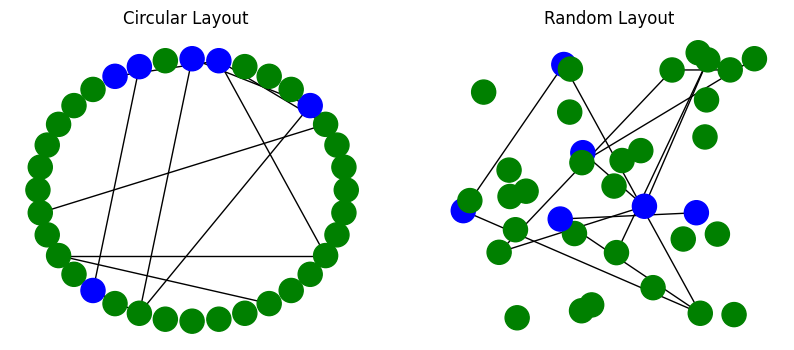

In [27]:
Nodes_to_plot = 30                                                                                # Number to plot nodes
G             = torch_geometric.utils.to_networkx(data_, to_undirected=True)                      # Convert pyg data to networkx
random_nodes  = np.random.randint(low=1, high=V_j_car, size=Nodes_to_plot, dtype=int).tolist() # Select random nodes
random_ppis   = np.random.randint(low=1, high=E_j_car, size=Nodes_to_plot//10, dtype=int).tolist() # selectrandom nodes
ppi_nodes     = edge_index[:,random_ppis].unique().tolist()                                       # Select nodes with PPI's
random_nodes.extend(ppi_nodes)                                                                    # appends lists
H = G.subgraph(random_nodes)                                                                      # Get node induced subgraph

## Define color maps to easily distinguish PPI
color_map = []
for node in H:
    if node in ppi_nodes:
        color_map.append('blue')
    else: 
        color_map.append('green') 
        
        
fig, ax = plt.subplots(1, 2,figsize=(10,4))
pos = nx.circular_layout(H, scale=1, center=None, dim=2)  
nx.draw(H,node_color=color_map,with_labels=False,pos=pos, ax=ax[0])
ax[0].set_title("Circular Layout")

pos = nx.random_layout(H)
nx.draw(H,node_color=color_map,with_labels=False,pos=pos,ax=ax[1])   
ax[1].set_title("Random Layout")
plt.show()
 

# Plot


##  1.B- Creating Negative edges 
The Dataset that we have collected only shows PPI's (that is positive interactions ). However only training a model with positive data whould create a usless predictor (one that would always predict there exists a PPI between two nodes). In order to train a model we need "negative" examples (Protein interactions that do not exists). to accomplish this we will use pyG's [`negative_sampling`](https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/utils/negative_sampling.html)

```python 
negative_sampling(    edge_index: Tensor,
                      num_nodes: Optional[Union[int, Tuple[int, int]]] = None,
                      num_neg_samples: Optional[int] = None,
                      method: str = "sparse",
                      force_undirected: bool = False) -> Tensor:
```

*  `edge_index (LongTensor):` The edge indices of shape (2,|E|). This corresponds to our true ppi
*  `num_nodes (int)`          The number of nodes total nodes in our graph  |N|
*  `num_neg_samples (int, optional)`: The (approximate) number of negative samples to return.
*  `force_undirected (bool, optional)`: If set to :obj:`True`, sampled negative edges will be undirected


Lets do a small test:

In [7]:
positive_ppi = torch.tensor([[3, 0, 0, 3],
                             [2, 3, 2, 1]])

negative_ppi  = negative_sampling(edge_index = positive_ppi, 
                                 num_nodes        = 10,
                                 num_neg_samples  = 6,
                                 method           = 'dense',
                                 force_undirected = True)

print("positive edges:")
print(negative_ppi)

print()

print("negative edges:")
print(negative_ppi)


positive edges:
tensor([[6, 1, 0, 7, 2, 9],
        [7, 2, 9, 6, 1, 0]])

negative edges:
tensor([[6, 1, 0, 7, 2, 9],
        [7, 2, 9, 6, 1, 0]])


Notice how the negative edges define do not overlap with the "real" edges

### 2. Define Algorithm

### 2.A- Graph Neural Network (GNN)

Four our task we will us a GNN with a $1$ layers of GraphSAGE convolution for message passing. Why? In a GNN the number of Layers is equivalent to $K$-hop message passings! This might lead to over-smoothing if $K$ is too big! Furthmore our graphs are really spars (less than 1% of the nodes in a give graph interact).

In [8]:
class GNNStack(torch.nn.Module):
    def __init__(self, input_dim:int, hidden_dim:int, output_dim:int, layers:int, dropout:float=0.3, return_embedding=False):
        """
            A stack of GraphSAGE Module 
            input_dim        <int>:   Input dimension
            hidden_dim       <int>:   Hidden dimension
            output_dim       <int>:   Output dimension
            layers           <int>:   Number of layers
            dropout          <float>: Dropout rate
            return_embedding <bool>:  Whether to return the return_embeddingedding of the input graph
        """
        
        super(GNNStack, self).__init__()
        graphSage_conv               = pyg.nn.SAGEConv
        self.dropout                 = dropout
        self.layers                  = layers
        self.return_embedding        = return_embedding

        ### Initalize the layers ###
        self.convs                   = nn.ModuleList()                      # ModuleList to hold the layers
        for l in range(self.layers):
            if l == 0:
                ### First layer  maps from input_dim to hidden_dim ###
                self.convs.append(graphSage_conv(input_dim, hidden_dim))
            else:
                ### All other layers map from hidden_dim to hidden_dim ###
                self.convs.append(graphSage_conv(hidden_dim, hidden_dim))

        # post-message-passing processing MLP
        self.post_mp = nn.Sequential(
                                     nn.Linear(hidden_dim, hidden_dim), 
                                     nn.Dropout(self.dropout),
                                     nn.Linear(hidden_dim, output_dim))

    def forward(self, x, edge_index):
        for i in range(self.layers):
            x = self.convs[i](x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.post_mp(x)

        # Return final layer of return_embeddingeddings if specified
        if self.return_embedding:
            return x

        # Else return class probabilities
        return F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)
    
    
### We will use This function to save our best model during trainnig ###
def save_torch_model(model,epoch,PATH:str,optimizer):
    print(f"Saving Model in Path {PATH}")
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer':optimizer,      
                }, PATH)

As stated before we will use an MLP that takes the Graphsage embedding vector of 2 nodes of a given graph ($z^l_i$, $z^l_j \in \mathbb{R}^{hidden}$ ) in order to compute the probability  whether there exists a link between the 2 given nodes (four our task this means the probability of two proteins interacting).

$$\text{ PPI Probability between  protein i and j = MLP}( z^l_i * z^l_j ) =  \text{MLP} (  z^l_j*z^l_i )$$

We take the element wise multiplication  of two proteins embeddings, instead of concatanating, in order to make an MLP that is invariant to the order we input two proteins 


In [9]:
class LinkPredictorMLP(nn.Module):
    def __init__(self, in_channels:int, hidden_channels:int, out_channels:int, n_layers:int,dropout_probabilty:float=0.3):
        """
        Args:
            in_channels (int):     Number of input features.
            hidden_channels (int): Number of hidden features.
            out_channels (int):    Number of output features.
            n_layers (int):        Number of MLP layers.
            dropout (float):       Dropout probability.
            """
        super(LinkPredictorMLP, self).__init__()
        self.dropout_probabilty    = dropout_probabilty  # dropout probability
        self.mlp_layers            = nn.ModuleList()     # ModuleList: is a list of modules
        self.non_linearity         = F.relu              # non-linearity
        
        for i in range(n_layers - 1):                                 
            if i == 0:
                self.mlp_layers.append(nn.Linear(in_channels, hidden_channels))          # input layer (in_channels, hidden_channels)
            else:
                self.mlp_layers.append(nn.Linear(hidden_channels, hidden_channels))      # hidden layers (hidden_channels, hidden_channels)

        self.mlp_layers.append(nn.Linear(hidden_channels, out_channels))                 # output layer (hidden_channels, out_channels)


    def reset_parameters(self):
        for mlp_layer in self.mlp_layers:
            mlp_layer.reset_parameters()

    def forward(self, x_i, x_j):
        x = x_i * x_j                                                     # element-wise multiplication
        for mlp_layer in self.mlp_layers[:-1]:                            # iterate over all layers except the last one
            x = mlp_layer(x)                                              # apply linear transformation
            x = self.non_linearity(x)                                     # Apply non linear activation function
            x = F.dropout(x, p=self.dropout_probabilty,training=self.training)      # Apply dropout
        x = self.mlp_layers[-1](x)                                        # apply linear transformation to the last layer
        x = torch.sigmoid(x)                                              # apply sigmoid activation function to get the probability
        return x

A GNN is trained by jointly maximizing the probabilty prediction of correct edges and minimizing the probability prediciton of the incorrect edges:

$Loss = -\log(prob\_pos\_edges  + ϵ) - \log(1-prob\_neg\_edges + ϵ)$ where the $ϵ=10^{-15}$ is added to each term for numerical stability

In [46]:
def train(model, link_predictor, dataset, optimizer,device:str="cuda"):
    """
    Runs offline training for model, link_predictor and node embeddings given the message
    edges and supervision edges.
    :param model: Torch Graph model used for updating node embeddings based on message passing 
        (If None, no embbeding is performed) 
    :param link_predictor: Torch model used for predicting whether edge exists or not
    :param emb: (N, d) Initial node embeddings for all N nodes in graph
    :param edge_index: (2, E) Edge index for all edges in the graph

    :param optimizer: Torch Optimizer to update model parameters
    :return: Average supervision loss over all positive (and correspondingly sampled negative) edges
    """
    if model != None:
        model.train()
    link_predictor.train()
    train_losses = []
    for x, edge_index in tqdm(dataset):                       # Get X and Index from Dataste
        optimizer.zero_grad()                                 # Reset Gradients
        edge_index     = torch.tensor(edge_index).T           # Reshape edge index     (2,|E|)
        x              = x.squeeze(dim=1)                     # Reshape Feature matrix (|N|,D)
        x , edge_index = x.to(device) , edge_index.to(device) # Move data to devices
        
        
        ### Step 1: Get Embeddings:
        # Run message passing on the inital node embeddings to get updated embeddings
        
        ### This model has the option of only running link predictor without graphsage, for that case the node embedding
        ### is equal to the original embedding (X)
        if model !=  None:
            node_emb = model(x, edge_index)  # Embed Bert Embeddigns with graphsage (N, d)   
        else:
            node_emb = x                     # Else (None) use Bert Embedddings
        # Predict the class probabilities on the batch of positive edges using link_predictor
        #print(node_emb[edge_index[0]].shape)
        pos_pred = link_predictor(node_emb[edge_index[0]], node_emb[edge_index[1]])   # (B, )

        # Sample negative edges (same number as number of positive edges) and predict class probabilities 
        # (2,N) = (2,P) = (2,|E|)
        neg_edge = negative_sampling(edge_index = edge_index,             # Possitve PPI's
                                 num_nodes        = x.shape[0],           # Total number of nodes in graph
                                 num_neg_samples  = edge_index.shape[1],  # Same Number of edges as in positive example
                                 method           = 'dense',              # Method for edge generation
                                 force_undirected = True)                 # Our graph is undirected
        
        
        neg_pred = link_predictor(node_emb[neg_edge[0]], node_emb[neg_edge[1]])         # (Ne,)

        # Compute the corresponding negative log likelihood loss on the positive and negative edges
        loss = -torch.log(pos_pred + 1e-15).mean() - torch.log(1 - neg_pred + 1e-15).mean()

        # Backpropagate and update parameters
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
    return sum(train_losses) / len(train_losses)

# Evaluation Loop

Since we use different organisms (which may or may not overlap analogous proteins) we can use all the PPIs for the train loop. However for the evaluation loop if we were to use all the PPI to embed the graph it would be practically cheating (since our embedding would have this information). Therefore (for the evaluation loop) we will randomly drop a percentage of PPIs by doing two steps:



1. Randomly permuted the edge_index

2. Dropping a percentage of PPI for embedding and leaving another percentage for inference

In [50]:
def evaluate(model, predictor,dataset,device="cpu",threshold=0.5,ppi_:int=0.9,verbose:bool=False,best_accuracy=0,show_extra_metrics:bool=False):
    if model != None:
        model.eval()
    possitive_acc  = 0 
    negative_acc   = 0
    batches        = 0
    if show_extra_metrics:
        yhat_total     = []
        y_total        = []
        
    for x, edge_index in dataset:                              # Get X and Index from Dataste

        edge_index      = torch.tensor(edge_index).T           # Reshape edge index     (2,|E|)
        number_of_edges =  edge_index.shape[1]                 # Retrive number of edges 
        permutations    =  torch.randperm(number_of_edges)     # Create Permutations for edge index
        edge_index      = edge_index[:,permutations]           # Run permutation
        limit           = int(ppi_*number_of_edges)            # get limit  (based on ppis to embed)
        ppi_index_embed = edge_index[:,0:limit]                # PPI to embed with GraphSage 
        ppi_index_infer = edge_index[:,limit:]                 # PPI to make inference
        
        x                    = x.squeeze(dim=1)                          # Reshape Feature matrix (|N|,D)
        x ,ppi_index_embed   = x.to(device) , ppi_index_embed.to(device) # Move data to devices
        if model !=  None:
            node_emb             = model(x,ppi_index_embed)              # Get all node embeddings
        else:
            node_emb = x                                                 # Else (None) use Bert Embedddings
            
        if verbose:
            print(f" {limit} Positive Protein Interactions were used to Embed a graph with {number_of_edges} ppi's")
        
        del ppi_index_embed 
        with torch.no_grad():
            ### Positive PPI ###
            positive_pairs_embeddings = node_emb[ppi_index_infer[0]].to(device), node_emb[ppi_index_infer[1]].to(device)
            predictions               = predictor(positive_pairs_embeddings[0], positive_pairs_embeddings[1]) 
            y                         = torch.ones_like(input=predictions)
            predictions,y             = predictions.cpu(),y.cpu()
            possitive_acc            += accuracy_score(predictions > threshold  ,y)
            if show_extra_metrics:
                yhat_total.extend(predictions.tolist())
                y_total.extend(y.tolist())
                
            else:
                del y, predictions , positive_pairs_embeddings,ppi_index_infer

            ### Negative PPI ##
            edge_index  =  edge_index.to(device)
            neg_edge    = negative_sampling(edge_index       = edge_index,        # Possitve PPI's
                                         num_nodes        = x.shape[0],           # Total number of nodes in graph
                                         num_neg_samples  = edge_index.shape[1],  # Same Number of edges as in positive example
                                         method           = 'dense',              # Method for edge generation
                                         force_undirected = True)                 # Our graph is undirected

            negative_pairs_embeddings = node_emb[neg_edge[0]].to(device), node_emb[neg_edge[1]].to(device)
            predictions               = predictor(negative_pairs_embeddings[0], negative_pairs_embeddings[1])   
            y                         = torch.zeros_like(input=predictions)
            predictions,y             = predictions.cpu(),y.cpu()
            negative_acc             += accuracy_score(predictions > threshold,y)
            if show_extra_metrics:
                yhat_total.extend(predictions.tolist())
                y_total.extend(y.tolist())
                
            else:
                del y,  predictions  ,negative_pairs_embeddings 
            batches +=1

    negative_acc  = negative_acc/batches
    possitive_acc = possitive_acc/batches
    total_acc     = 0.5*possitive_acc  + 0.5*negative_acc
    if show_extra_metrics == False:
        print(f"Sensitivity (poss_acc):{possitive_acc:.4f} Specificity (negative_acc):{negative_acc:.4f} accuracy:{total_acc:.4f}")
    
    elif show_extra_metrics == True:
        
        fig, ax = plt.subplots(1, 2,figsize=(10,2))
        fpr, tpr, thresholds = metrics.roc_curve( y_total, yhat_total)
        
        sens      =  tpr
        spec      =  1 - fpr
        j         = sens + spec -1
        opt_index = np.where(j == np.max(j))[0][0]
        op_point  = thresholds[opt_index]
        
        print(f"Youdens  index: {op_point:.4f} Sensitivity: {round(sens[opt_index],4)} Specificity: {round(spec[opt_index],4)}")
       
        ax[0].set_title("ROC Curve")
        ax[1].set_title("Confussion Matrix")
        if model == None:
            ax[0].plot(fpr,tpr,label="MLP") 
        else:
            ax[0].plot(fpr,tpr,label="GraphSage+MLP") 
        ax[0].plot([0, 1], [0, 1], 'k--')
        ax[0].set_ylabel('True Positive Rate')
        ax[0].set_xlabel('False Positive Rate')
        ax[0].legend()
       
    
        cfm = metrics.confusion_matrix(y_total, np.array(yhat_total)> op_point)
        
        cmn = cfm.astype('float') / cfm.sum(axis=1)[:, np.newaxis] # Normalise
        disp = ConfusionMatrixDisplay(cmn)
        disp.plot(ax=ax[1])
        
        plt.show()
     
    return total_acc 



## 3 Time To train 
We have everything we need to train, But before we do so lets visualize Initiate and Visualzie our model!

In [12]:
epochs        = 500
hidden_dim    = 524      # 256 
dropout       = 0.7
num_layers    = 3
learning_rate = 1e-4
node_emb_dim  = 1024

In [13]:
model          = GNNStack(node_emb_dim, hidden_dim, hidden_dim, num_layers, dropout, return_embedding=True).to(device) # the graph neural network that takes all the node embeddings as inputs to message pass and agregate
link_predictor = LinkPredictorMLP(hidden_dim, hidden_dim, 1, num_layers , dropout).to(device) # the MLP that takes embeddings of a pair of nodes and predicts the existence of an edge between them
#optimizer      = torch.optim.AdamW(list(model.parameters()) + list(link_predictor.parameters() ), lr=learning_rate, weight_decay=1e-4)
optimizer      = torch.optim.Adam(list(model.parameters()) + list(link_predictor.parameters() ), lr=learning_rate)

print(model)
print(link_predictor)
print(f"Models Loaded to {device}")

GNNStack(
  (convs): ModuleList(
    (0): SAGEConv(1024, 524, aggr=mean)
    (1): SAGEConv(524, 524, aggr=mean)
    (2): SAGEConv(524, 524, aggr=mean)
  )
  (post_mp): Sequential(
    (0): Linear(in_features=524, out_features=524, bias=True)
    (1): Dropout(p=0.7, inplace=False)
    (2): Linear(in_features=524, out_features=524, bias=True)
  )
)
LinkPredictorMLP(
  (mlp_layers): ModuleList(
    (0): Linear(in_features=524, out_features=524, bias=True)
    (1): Linear(in_features=524, out_features=524, bias=True)
    (2): Linear(in_features=524, out_features=1, bias=True)
  )
)
Models Loaded to cuda


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 1: loss: 0.87076
Youdens  index: 0.6106 Sensitivity: 0.9549 Specificity: 0.6533


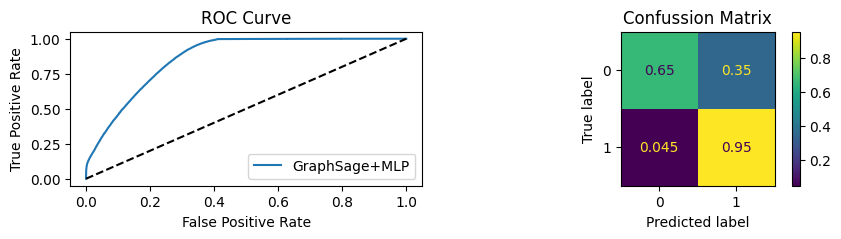

Replacing models:   
with: Best models at GraphSage_epoch_1.pt  link_predictor_epoch_1.pt
Saving Model in Path GraphSage_epoch_1.pt
Saving Model in Path link_predictor_epoch_1.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 2: loss: 0.75244
Sensitivity (poss_acc):0.9694 Specificity (negative_acc):0.6608 accuracy:0.8151
Replacing models: GraphSage_epoch_1.pt  link_predictor_epoch_1.pt
with: Best models at GraphSage_epoch_2.pt  link_predictor_epoch_2.pt
Saving Model in Path GraphSage_epoch_2.pt
Saving Model in Path link_predictor_epoch_2.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 3: loss: 0.70447
Sensitivity (poss_acc):0.9321 Specificity (negative_acc):0.7490 accuracy:0.8405
Replacing models: GraphSage_epoch_2.pt  link_predictor_epoch_2.pt
with: Best models at GraphSage_epoch_3.pt  link_predictor_epoch_3.pt
Saving Model in Path GraphSage_epoch_3.pt
Saving Model in Path link_predictor_epoch_3.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 4: loss: 0.68816
Sensitivity (poss_acc):0.8940 Specificity (negative_acc):0.7987 accuracy:0.8464
Replacing models: GraphSage_epoch_3.pt  link_predictor_epoch_3.pt
with: Best models at GraphSage_epoch_4.pt  link_predictor_epoch_4.pt
Saving Model in Path GraphSage_epoch_4.pt
Saving Model in Path link_predictor_epoch_4.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 5: loss: 0.66562
Sensitivity (poss_acc):0.8816 Specificity (negative_acc):0.8216 accuracy:0.8516
Replacing models: GraphSage_epoch_4.pt  link_predictor_epoch_4.pt
with: Best models at GraphSage_epoch_5.pt  link_predictor_epoch_5.pt
Saving Model in Path GraphSage_epoch_5.pt
Saving Model in Path link_predictor_epoch_5.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 6: loss: 0.63984
Sensitivity (poss_acc):0.9087 Specificity (negative_acc):0.8128 accuracy:0.8608
Replacing models: GraphSage_epoch_5.pt  link_predictor_epoch_5.pt
with: Best models at GraphSage_epoch_6.pt  link_predictor_epoch_6.pt
Saving Model in Path GraphSage_epoch_6.pt
Saving Model in Path link_predictor_epoch_6.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 7: loss: 0.62015
Sensitivity (poss_acc):0.9334 Specificity (negative_acc):0.7993 accuracy:0.8663
Replacing models: GraphSage_epoch_6.pt  link_predictor_epoch_6.pt
with: Best models at GraphSage_epoch_7.pt  link_predictor_epoch_7.pt
Saving Model in Path GraphSage_epoch_7.pt
Saving Model in Path link_predictor_epoch_7.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 8: loss: 0.60017
Sensitivity (poss_acc):0.9584 Specificity (negative_acc):0.7927 accuracy:0.8755
Replacing models: GraphSage_epoch_7.pt  link_predictor_epoch_7.pt
with: Best models at GraphSage_epoch_8.pt  link_predictor_epoch_8.pt
Saving Model in Path GraphSage_epoch_8.pt
Saving Model in Path link_predictor_epoch_8.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 9: loss: 0.58271
Sensitivity (poss_acc):0.9690 Specificity (negative_acc):0.7737 accuracy:0.8714


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 10: loss: 0.56765
Sensitivity (poss_acc):0.9708 Specificity (negative_acc):0.7771 accuracy:0.8739


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 11: loss: 0.55331
Sensitivity (poss_acc):0.9758 Specificity (negative_acc):0.7810 accuracy:0.8784
Replacing models: GraphSage_epoch_8.pt  link_predictor_epoch_8.pt
with: Best models at GraphSage_epoch_11.pt  link_predictor_epoch_11.pt
Saving Model in Path GraphSage_epoch_11.pt
Saving Model in Path link_predictor_epoch_11.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 12: loss: 0.53866
Sensitivity (poss_acc):0.9746 Specificity (negative_acc):0.7899 accuracy:0.8822
Replacing models: GraphSage_epoch_11.pt  link_predictor_epoch_11.pt
with: Best models at GraphSage_epoch_12.pt  link_predictor_epoch_12.pt
Saving Model in Path GraphSage_epoch_12.pt
Saving Model in Path link_predictor_epoch_12.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 13: loss: 0.52363
Sensitivity (poss_acc):0.9746 Specificity (negative_acc):0.7996 accuracy:0.8871
Replacing models: GraphSage_epoch_12.pt  link_predictor_epoch_12.pt
with: Best models at GraphSage_epoch_13.pt  link_predictor_epoch_13.pt
Saving Model in Path GraphSage_epoch_13.pt
Saving Model in Path link_predictor_epoch_13.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 14: loss: 0.51133
Sensitivity (poss_acc):0.9729 Specificity (negative_acc):0.8101 accuracy:0.8915
Replacing models: GraphSage_epoch_13.pt  link_predictor_epoch_13.pt
with: Best models at GraphSage_epoch_14.pt  link_predictor_epoch_14.pt
Saving Model in Path GraphSage_epoch_14.pt
Saving Model in Path link_predictor_epoch_14.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 15: loss: 0.50256
Sensitivity (poss_acc):0.9731 Specificity (negative_acc):0.8119 accuracy:0.8925
Replacing models: GraphSage_epoch_14.pt  link_predictor_epoch_14.pt
with: Best models at GraphSage_epoch_15.pt  link_predictor_epoch_15.pt
Saving Model in Path GraphSage_epoch_15.pt
Saving Model in Path link_predictor_epoch_15.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 16: loss: 0.49453
Sensitivity (poss_acc):0.9720 Specificity (negative_acc):0.8184 accuracy:0.8952
Replacing models: GraphSage_epoch_15.pt  link_predictor_epoch_15.pt
with: Best models at GraphSage_epoch_16.pt  link_predictor_epoch_16.pt
Saving Model in Path GraphSage_epoch_16.pt
Saving Model in Path link_predictor_epoch_16.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 17: loss: 0.48768
Sensitivity (poss_acc):0.9699 Specificity (negative_acc):0.8211 accuracy:0.8955
Replacing models: GraphSage_epoch_16.pt  link_predictor_epoch_16.pt
with: Best models at GraphSage_epoch_17.pt  link_predictor_epoch_17.pt
Saving Model in Path GraphSage_epoch_17.pt
Saving Model in Path link_predictor_epoch_17.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 18: loss: 0.48151
Sensitivity (poss_acc):0.9698 Specificity (negative_acc):0.8256 accuracy:0.8977
Replacing models: GraphSage_epoch_17.pt  link_predictor_epoch_17.pt
with: Best models at GraphSage_epoch_18.pt  link_predictor_epoch_18.pt
Saving Model in Path GraphSage_epoch_18.pt
Saving Model in Path link_predictor_epoch_18.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 19: loss: 0.47317
Sensitivity (poss_acc):0.9724 Specificity (negative_acc):0.8270 accuracy:0.8997
Replacing models: GraphSage_epoch_18.pt  link_predictor_epoch_18.pt
with: Best models at GraphSage_epoch_19.pt  link_predictor_epoch_19.pt
Saving Model in Path GraphSage_epoch_19.pt
Saving Model in Path link_predictor_epoch_19.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 20: loss: 0.46558
Youdens  index: 0.6895 Sensitivity: 0.9447 Specificity: 0.8765


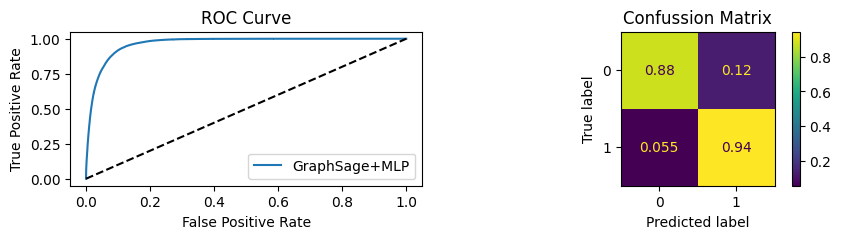

Replacing models: GraphSage_epoch_19.pt  link_predictor_epoch_19.pt
with: Best models at GraphSage_epoch_20.pt  link_predictor_epoch_20.pt
Saving Model in Path GraphSage_epoch_20.pt
Saving Model in Path link_predictor_epoch_20.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 21: loss: 0.46078
Sensitivity (poss_acc):0.9690 Specificity (negative_acc):0.8329 accuracy:0.9009


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 22: loss: 0.4537
Sensitivity (poss_acc):0.9694 Specificity (negative_acc):0.8375 accuracy:0.9035
Replacing models: GraphSage_epoch_20.pt  link_predictor_epoch_20.pt
with: Best models at GraphSage_epoch_22.pt  link_predictor_epoch_22.pt
Saving Model in Path GraphSage_epoch_22.pt
Saving Model in Path link_predictor_epoch_22.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 23: loss: 0.44743
Sensitivity (poss_acc):0.9647 Specificity (negative_acc):0.8418 accuracy:0.9032


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 24: loss: 0.44126
Sensitivity (poss_acc):0.9625 Specificity (negative_acc):0.8518 accuracy:0.9072
Replacing models: GraphSage_epoch_22.pt  link_predictor_epoch_22.pt
with: Best models at GraphSage_epoch_24.pt  link_predictor_epoch_24.pt
Saving Model in Path GraphSage_epoch_24.pt
Saving Model in Path link_predictor_epoch_24.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 25: loss: 0.43587
Sensitivity (poss_acc):0.9601 Specificity (negative_acc):0.8550 accuracy:0.9076
Replacing models: GraphSage_epoch_24.pt  link_predictor_epoch_24.pt
with: Best models at GraphSage_epoch_25.pt  link_predictor_epoch_25.pt
Saving Model in Path GraphSage_epoch_25.pt
Saving Model in Path link_predictor_epoch_25.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 26: loss: 0.42811
Sensitivity (poss_acc):0.9663 Specificity (negative_acc):0.8629 accuracy:0.9146
Replacing models: GraphSage_epoch_25.pt  link_predictor_epoch_25.pt
with: Best models at GraphSage_epoch_26.pt  link_predictor_epoch_26.pt
Saving Model in Path GraphSage_epoch_26.pt
Saving Model in Path link_predictor_epoch_26.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 27: loss: 0.42385
Sensitivity (poss_acc):0.9687 Specificity (negative_acc):0.8531 accuracy:0.9109


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 28: loss: 0.41945
Sensitivity (poss_acc):0.9621 Specificity (negative_acc):0.8692 accuracy:0.9156
Replacing models: GraphSage_epoch_26.pt  link_predictor_epoch_26.pt
with: Best models at GraphSage_epoch_28.pt  link_predictor_epoch_28.pt
Saving Model in Path GraphSage_epoch_28.pt
Saving Model in Path link_predictor_epoch_28.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 29: loss: 0.41225
Sensitivity (poss_acc):0.9650 Specificity (negative_acc):0.8702 accuracy:0.9176
Replacing models: GraphSage_epoch_28.pt  link_predictor_epoch_28.pt
with: Best models at GraphSage_epoch_29.pt  link_predictor_epoch_29.pt
Saving Model in Path GraphSage_epoch_29.pt
Saving Model in Path link_predictor_epoch_29.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 30: loss: 0.40887
Sensitivity (poss_acc):0.9656 Specificity (negative_acc):0.8701 accuracy:0.9178
Replacing models: GraphSage_epoch_29.pt  link_predictor_epoch_29.pt
with: Best models at GraphSage_epoch_30.pt  link_predictor_epoch_30.pt
Saving Model in Path GraphSage_epoch_30.pt
Saving Model in Path link_predictor_epoch_30.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 31: loss: 0.40365
Sensitivity (poss_acc):0.9648 Specificity (negative_acc):0.8724 accuracy:0.9186
Replacing models: GraphSage_epoch_30.pt  link_predictor_epoch_30.pt
with: Best models at GraphSage_epoch_31.pt  link_predictor_epoch_31.pt
Saving Model in Path GraphSage_epoch_31.pt
Saving Model in Path link_predictor_epoch_31.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 32: loss: 0.40169
Sensitivity (poss_acc):0.9668 Specificity (negative_acc):0.8712 accuracy:0.9190
Replacing models: GraphSage_epoch_31.pt  link_predictor_epoch_31.pt
with: Best models at GraphSage_epoch_32.pt  link_predictor_epoch_32.pt
Saving Model in Path GraphSage_epoch_32.pt
Saving Model in Path link_predictor_epoch_32.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 33: loss: 0.39683
Sensitivity (poss_acc):0.9681 Specificity (negative_acc):0.8689 accuracy:0.9185


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 34: loss: 0.39521
Sensitivity (poss_acc):0.9677 Specificity (negative_acc):0.8748 accuracy:0.9213
Replacing models: GraphSage_epoch_32.pt  link_predictor_epoch_32.pt
with: Best models at GraphSage_epoch_34.pt  link_predictor_epoch_34.pt
Saving Model in Path GraphSage_epoch_34.pt
Saving Model in Path link_predictor_epoch_34.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 35: loss: 0.39125
Sensitivity (poss_acc):0.9688 Specificity (negative_acc):0.8724 accuracy:0.9206


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 36: loss: 0.3883
Sensitivity (poss_acc):0.9688 Specificity (negative_acc):0.8755 accuracy:0.9221
Replacing models: GraphSage_epoch_34.pt  link_predictor_epoch_34.pt
with: Best models at GraphSage_epoch_36.pt  link_predictor_epoch_36.pt
Saving Model in Path GraphSage_epoch_36.pt
Saving Model in Path link_predictor_epoch_36.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 37: loss: 0.38648
Sensitivity (poss_acc):0.9681 Specificity (negative_acc):0.8809 accuracy:0.9245
Replacing models: GraphSage_epoch_36.pt  link_predictor_epoch_36.pt
with: Best models at GraphSage_epoch_37.pt  link_predictor_epoch_37.pt
Saving Model in Path GraphSage_epoch_37.pt
Saving Model in Path link_predictor_epoch_37.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 38: loss: 0.3863
Sensitivity (poss_acc):0.9663 Specificity (negative_acc):0.8839 accuracy:0.9251
Replacing models: GraphSage_epoch_37.pt  link_predictor_epoch_37.pt
with: Best models at GraphSage_epoch_38.pt  link_predictor_epoch_38.pt
Saving Model in Path GraphSage_epoch_38.pt
Saving Model in Path link_predictor_epoch_38.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 39: loss: 0.38021
Sensitivity (poss_acc):0.9652 Specificity (negative_acc):0.8842 accuracy:0.9247


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 40: loss: 0.37916
Youdens  index: 0.6097 Sensitivity: 0.9575 Specificity: 0.9048


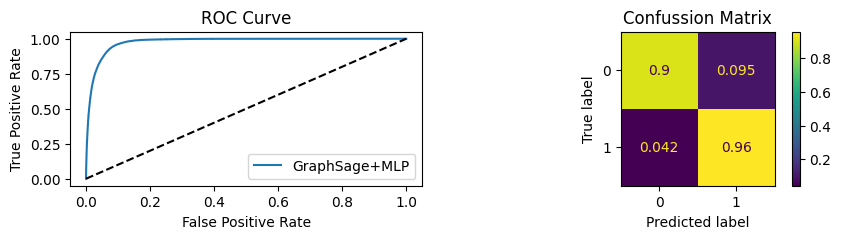

Replacing models: GraphSage_epoch_38.pt  link_predictor_epoch_38.pt
with: Best models at GraphSage_epoch_40.pt  link_predictor_epoch_40.pt
Saving Model in Path GraphSage_epoch_40.pt
Saving Model in Path link_predictor_epoch_40.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 41: loss: 0.37754
Sensitivity (poss_acc):0.9708 Specificity (negative_acc):0.8775 accuracy:0.9241


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 42: loss: 0.37442
Sensitivity (poss_acc):0.9722 Specificity (negative_acc):0.8792 accuracy:0.9257


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 43: loss: 0.37462
Sensitivity (poss_acc):0.9669 Specificity (negative_acc):0.8858 accuracy:0.9264
Replacing models: GraphSage_epoch_40.pt  link_predictor_epoch_40.pt
with: Best models at GraphSage_epoch_43.pt  link_predictor_epoch_43.pt
Saving Model in Path GraphSage_epoch_43.pt
Saving Model in Path link_predictor_epoch_43.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 44: loss: 0.36912
Sensitivity (poss_acc):0.9690 Specificity (negative_acc):0.8885 accuracy:0.9288
Replacing models: GraphSage_epoch_43.pt  link_predictor_epoch_43.pt
with: Best models at GraphSage_epoch_44.pt  link_predictor_epoch_44.pt
Saving Model in Path GraphSage_epoch_44.pt
Saving Model in Path link_predictor_epoch_44.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 45: loss: 0.36761
Sensitivity (poss_acc):0.9679 Specificity (negative_acc):0.8864 accuracy:0.9271


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 46: loss: 0.36501
Sensitivity (poss_acc):0.9703 Specificity (negative_acc):0.8881 accuracy:0.9292
Replacing models: GraphSage_epoch_44.pt  link_predictor_epoch_44.pt
with: Best models at GraphSage_epoch_46.pt  link_predictor_epoch_46.pt
Saving Model in Path GraphSage_epoch_46.pt
Saving Model in Path link_predictor_epoch_46.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 47: loss: 0.36202
Epoch 51: loss: 0.35363
Sensitivity (poss_acc):0.9698 Specificity (negative_acc):0.8920 accuracy:0.9309
Replacing models: GraphSage_epoch_48.pt  link_predictor_epoch_48.pt
with: Best models at GraphSage_epoch_51.pt  link_predictor_epoch_51.pt
Saving Model in Path GraphSage_epoch_51.pt
Saving Model in Path link_predictor_epoch_51.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 52: loss: 0.35111
Sensitivity (poss_acc):0.9685 Specificity (negative_acc):0.8962 accuracy:0.9323
Replacing models: GraphSage_epoch_51.pt  link_predictor_epoch_51.pt
with: Best models at GraphSage_epoch_52.pt  link_predictor_epoch_52.pt
Saving Model in Path GraphSage_epoch_52.pt
Saving Model in Path link_predictor_epoch_52.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 53: loss: 0.34946
Sensitivity (poss_acc):0.9697 Specificity (negative_acc):0.8950 accuracy:0.9324
Replacing models: GraphSage_epoch_52.pt  link_predictor_epoch_52.pt
with: Best models at GraphSage_epoch_53.pt  link_predictor_epoch_53.pt
Saving Model in Path GraphSage_epoch_53.pt
Saving Model in Path link_predictor_epoch_53.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 54: loss: 0.34708
Sensitivity (poss_acc):0.9695 Specificity (negative_acc):0.8958 accuracy:0.9327
Replacing models: GraphSage_epoch_53.pt  link_predictor_epoch_53.pt
with: Best models at GraphSage_epoch_54.pt  link_predictor_epoch_54.pt
Saving Model in Path GraphSage_epoch_54.pt
Saving Model in Path link_predictor_epoch_54.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 55: loss: 0.34412
Sensitivity (poss_acc):0.9691 Specificity (negative_acc):0.8983 accuracy:0.9337
Replacing models: GraphSage_epoch_54.pt  link_predictor_epoch_54.pt
with: Best models at GraphSage_epoch_55.pt  link_predictor_epoch_55.pt
Saving Model in Path GraphSage_epoch_55.pt
Saving Model in Path link_predictor_epoch_55.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 56: loss: 0.34121
Sensitivity (poss_acc):0.9694 Specificity (negative_acc):0.8985 accuracy:0.9339
Replacing models: GraphSage_epoch_55.pt  link_predictor_epoch_55.pt
with: Best models at GraphSage_epoch_56.pt  link_predictor_epoch_56.pt
Saving Model in Path GraphSage_epoch_56.pt
Saving Model in Path link_predictor_epoch_56.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 57: loss: 0.33864
Sensitivity (poss_acc):0.9691 Specificity (negative_acc):0.9004 accuracy:0.9347
Replacing models: GraphSage_epoch_56.pt  link_predictor_epoch_56.pt
with: Best models at GraphSage_epoch_57.pt  link_predictor_epoch_57.pt
Saving Model in Path GraphSage_epoch_57.pt
Saving Model in Path link_predictor_epoch_57.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 58: loss: 0.33763
Sensitivity (poss_acc):0.9702 Specificity (negative_acc):0.8968 accuracy:0.9335


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 59: loss: 0.33612
Sensitivity (poss_acc):0.9704 Specificity (negative_acc):0.8941 accuracy:0.9323


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 60: loss: 0.33419
Youdens  index: 0.6010 Sensitivity: 0.9629 Specificity: 0.9135


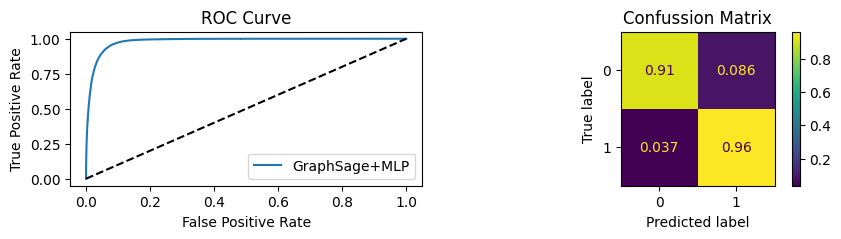

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 61: loss: 0.3338
Sensitivity (poss_acc):0.9700 Specificity (negative_acc):0.9035 accuracy:0.9368
Replacing models: GraphSage_epoch_57.pt  link_predictor_epoch_57.pt
with: Best models at GraphSage_epoch_61.pt  link_predictor_epoch_61.pt
Saving Model in Path GraphSage_epoch_61.pt
Saving Model in Path link_predictor_epoch_61.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 62: loss: 0.32949
Sensitivity (poss_acc):0.9684 Specificity (negative_acc):0.9085 accuracy:0.9384
Replacing models: GraphSage_epoch_61.pt  link_predictor_epoch_61.pt
with: Best models at GraphSage_epoch_62.pt  link_predictor_epoch_62.pt
Saving Model in Path GraphSage_epoch_62.pt
Saving Model in Path link_predictor_epoch_62.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 63: loss: 0.32731
Sensitivity (poss_acc):0.9652 Specificity (negative_acc):0.9096 accuracy:0.9374


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 64: loss: 0.32515
Sensitivity (poss_acc):0.9660 Specificity (negative_acc):0.9097 accuracy:0.9378


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 65: loss: 0.32234
Sensitivity (poss_acc):0.9706 Specificity (negative_acc):0.9064 accuracy:0.9385
Replacing models: GraphSage_epoch_62.pt  link_predictor_epoch_62.pt
with: Best models at GraphSage_epoch_65.pt  link_predictor_epoch_65.pt
Saving Model in Path GraphSage_epoch_65.pt
Saving Model in Path link_predictor_epoch_65.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 66: loss: 0.31965
Sensitivity (poss_acc):0.9717 Specificity (negative_acc):0.9042 accuracy:0.9379


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 67: loss: 0.32053
Sensitivity (poss_acc):0.9668 Specificity (negative_acc):0.9099 accuracy:0.9384


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 68: loss: 0.31623
Sensitivity (poss_acc):0.9665 Specificity (negative_acc):0.9135 accuracy:0.9400
Replacing models: GraphSage_epoch_65.pt  link_predictor_epoch_65.pt
with: Best models at GraphSage_epoch_68.pt  link_predictor_epoch_68.pt
Saving Model in Path GraphSage_epoch_68.pt
Saving Model in Path link_predictor_epoch_68.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 69: loss: 0.31385
Sensitivity (poss_acc):0.9656 Specificity (negative_acc):0.9171 accuracy:0.9414
Replacing models: GraphSage_epoch_68.pt  link_predictor_epoch_68.pt
with: Best models at GraphSage_epoch_69.pt  link_predictor_epoch_69.pt
Saving Model in Path GraphSage_epoch_69.pt
Saving Model in Path link_predictor_epoch_69.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 70: loss: 0.31127
Sensitivity (poss_acc):0.9635 Specificity (negative_acc):0.9192 accuracy:0.9413


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 71: loss: 0.30857
Sensitivity (poss_acc):0.9664 Specificity (negative_acc):0.9167 accuracy:0.9415
Replacing models: GraphSage_epoch_69.pt  link_predictor_epoch_69.pt
with: Best models at GraphSage_epoch_71.pt  link_predictor_epoch_71.pt
Saving Model in Path GraphSage_epoch_71.pt
Saving Model in Path link_predictor_epoch_71.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 72: loss: 0.30696
Sensitivity (poss_acc):0.9661 Specificity (negative_acc):0.9178 accuracy:0.9419
Replacing models: GraphSage_epoch_71.pt  link_predictor_epoch_71.pt
with: Best models at GraphSage_epoch_72.pt  link_predictor_epoch_72.pt
Saving Model in Path GraphSage_epoch_72.pt
Saving Model in Path link_predictor_epoch_72.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 73: loss: 0.30466
Sensitivity (poss_acc):0.9684 Specificity (negative_acc):0.9167 accuracy:0.9425
Replacing models: GraphSage_epoch_72.pt  link_predictor_epoch_72.pt
with: Best models at GraphSage_epoch_73.pt  link_predictor_epoch_73.pt
Saving Model in Path GraphSage_epoch_73.pt
Saving Model in Path link_predictor_epoch_73.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 74: loss: 0.30312
Sensitivity (poss_acc):0.9713 Specificity (negative_acc):0.9162 accuracy:0.9438
Replacing models: GraphSage_epoch_73.pt  link_predictor_epoch_73.pt
with: Best models at GraphSage_epoch_74.pt  link_predictor_epoch_74.pt
Saving Model in Path GraphSage_epoch_74.pt
Saving Model in Path link_predictor_epoch_74.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 75: loss: 0.30136
Sensitivity (poss_acc):0.9691 Specificity (negative_acc):0.9138 accuracy:0.9414


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 76: loss: 0.30145
Sensitivity (poss_acc):0.9698 Specificity (negative_acc):0.9175 accuracy:0.9436


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 77: loss: 0.29976
Sensitivity (poss_acc):0.9659 Specificity (negative_acc):0.9202 accuracy:0.9430


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 78: loss: 0.29932
Sensitivity (poss_acc):0.9641 Specificity (negative_acc):0.9240 accuracy:0.9441
Replacing models: GraphSage_epoch_74.pt  link_predictor_epoch_74.pt
with: Best models at GraphSage_epoch_78.pt  link_predictor_epoch_78.pt
Saving Model in Path GraphSage_epoch_78.pt
Saving Model in Path link_predictor_epoch_78.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 79: loss: 0.29839
Sensitivity (poss_acc):0.9685 Specificity (negative_acc):0.9227 accuracy:0.9456
Replacing models: GraphSage_epoch_78.pt  link_predictor_epoch_78.pt
with: Best models at GraphSage_epoch_79.pt  link_predictor_epoch_79.pt
Saving Model in Path GraphSage_epoch_79.pt
Saving Model in Path link_predictor_epoch_79.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 80: loss: 0.29657
Youdens  index: 0.5627 Sensitivity: 0.9597 Specificity: 0.9352


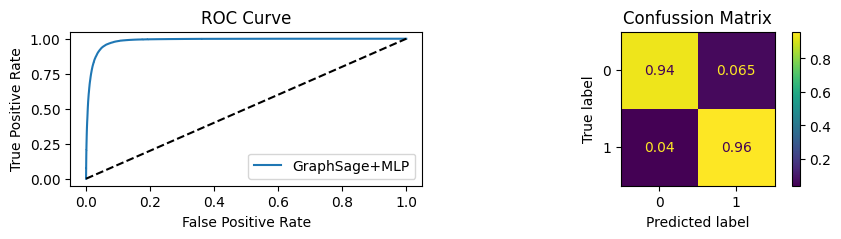

Replacing models: GraphSage_epoch_79.pt  link_predictor_epoch_79.pt
with: Best models at GraphSage_epoch_80.pt  link_predictor_epoch_80.pt
Saving Model in Path GraphSage_epoch_80.pt
Saving Model in Path link_predictor_epoch_80.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 81: loss: 0.29545
Sensitivity (poss_acc):0.9664 Specificity (negative_acc):0.9247 accuracy:0.9456


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 82: loss: 0.2937
Sensitivity (poss_acc):0.9591 Specificity (negative_acc):0.9307 accuracy:0.9449


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 83: loss: 0.2954
Sensitivity (poss_acc):0.9588 Specificity (negative_acc):0.9326 accuracy:0.9457
Replacing models: GraphSage_epoch_80.pt  link_predictor_epoch_80.pt
with: Best models at GraphSage_epoch_83.pt  link_predictor_epoch_83.pt
Saving Model in Path GraphSage_epoch_83.pt
Saving Model in Path link_predictor_epoch_83.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 84: loss: 0.29452
Sensitivity (poss_acc):0.9670 Specificity (negative_acc):0.9260 accuracy:0.9465
Replacing models: GraphSage_epoch_83.pt  link_predictor_epoch_83.pt
with: Best models at GraphSage_epoch_84.pt  link_predictor_epoch_84.pt
Saving Model in Path GraphSage_epoch_84.pt
Saving Model in Path link_predictor_epoch_84.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 85: loss: 0.2908
Sensitivity (poss_acc):0.9656 Specificity (negative_acc):0.9269 accuracy:0.9463


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 86: loss: 0.28976
Sensitivity (poss_acc):0.9639 Specificity (negative_acc):0.9325 accuracy:0.9482
Replacing models: GraphSage_epoch_84.pt  link_predictor_epoch_84.pt
with: Best models at GraphSage_epoch_86.pt  link_predictor_epoch_86.pt
Saving Model in Path GraphSage_epoch_86.pt
Saving Model in Path link_predictor_epoch_86.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 87: loss: 0.28861
Sensitivity (poss_acc):0.9647 Specificity (negative_acc):0.9270 accuracy:0.9459


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 88: loss: 0.28763
Sensitivity (poss_acc):0.9590 Specificity (negative_acc):0.9343 accuracy:0.9467


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 89: loss: 0.28751
Sensitivity (poss_acc):0.9577 Specificity (negative_acc):0.9368 accuracy:0.9473


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 90: loss: 0.28784
Sensitivity (poss_acc):0.9605 Specificity (negative_acc):0.9348 accuracy:0.9476


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 91: loss: 0.28543
Sensitivity (poss_acc):0.9566 Specificity (negative_acc):0.9363 accuracy:0.9465


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 92: loss: 0.28649
Sensitivity (poss_acc):0.9560 Specificity (negative_acc):0.9370 accuracy:0.9465


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 93: loss: 0.28586
Sensitivity (poss_acc):0.9573 Specificity (negative_acc):0.9400 accuracy:0.9487
Replacing models: GraphSage_epoch_86.pt  link_predictor_epoch_86.pt
with: Best models at GraphSage_epoch_93.pt  link_predictor_epoch_93.pt
Saving Model in Path GraphSage_epoch_93.pt
Saving Model in Path link_predictor_epoch_93.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 94: loss: 0.28638
Sensitivity (poss_acc):0.9482 Specificity (negative_acc):0.9434 accuracy:0.9458


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 95: loss: 0.28615
Sensitivity (poss_acc):0.9465 Specificity (negative_acc):0.9429 accuracy:0.9447


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 96: loss: 0.28628
Sensitivity (poss_acc):0.9523 Specificity (negative_acc):0.9431 accuracy:0.9477


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 97: loss: 0.28469
Sensitivity (poss_acc):0.9531 Specificity (negative_acc):0.9414 accuracy:0.9472


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 98: loss: 0.28472
Sensitivity (poss_acc):0.9509 Specificity (negative_acc):0.9410 accuracy:0.9460


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 99: loss: 0.28292
Sensitivity (poss_acc):0.9505 Specificity (negative_acc):0.9403 accuracy:0.9454


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 100: loss: 0.28313
Youdens  index: 0.4457 Sensitivity: 0.9681 Specificity: 0.9338


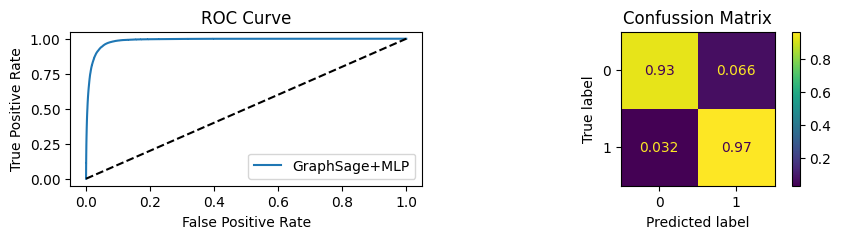

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 101: loss: 0.27975
Sensitivity (poss_acc):0.9609 Specificity (negative_acc):0.9345 accuracy:0.9477


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 102: loss: 0.2789
Sensitivity (poss_acc):0.9588 Specificity (negative_acc):0.9377 accuracy:0.9482


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 103: loss: 0.27827
Sensitivity (poss_acc):0.9610 Specificity (negative_acc):0.9334 accuracy:0.9472


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 104: loss: 0.27745
Sensitivity (poss_acc):0.9625 Specificity (negative_acc):0.9336 accuracy:0.9481


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 105: loss: 0.27713
Sensitivity (poss_acc):0.9649 Specificity (negative_acc):0.9331 accuracy:0.9490
Replacing models: GraphSage_epoch_93.pt  link_predictor_epoch_93.pt
with: Best models at GraphSage_epoch_105.pt  link_predictor_epoch_105.pt
Saving Model in Path GraphSage_epoch_105.pt
Saving Model in Path link_predictor_epoch_105.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 106: loss: 0.27613
Sensitivity (poss_acc):0.9636 Specificity (negative_acc):0.9357 accuracy:0.9497
Replacing models: GraphSage_epoch_105.pt  link_predictor_epoch_105.pt
with: Best models at GraphSage_epoch_106.pt  link_predictor_epoch_106.pt
Saving Model in Path GraphSage_epoch_106.pt
Saving Model in Path link_predictor_epoch_106.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 107: loss: 0.2751
Sensitivity (poss_acc):0.9664 Specificity (negative_acc):0.9279 accuracy:0.9472


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 108: loss: 0.27444
Sensitivity (poss_acc):0.9636 Specificity (negative_acc):0.9293 accuracy:0.9464


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 109: loss: 0.2735
Sensitivity (poss_acc):0.9713 Specificity (negative_acc):0.9264 accuracy:0.9488


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 110: loss: 0.2724
Sensitivity (poss_acc):0.9687 Specificity (negative_acc):0.9300 accuracy:0.9494


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 111: loss: 0.27183
Sensitivity (poss_acc):0.9610 Specificity (negative_acc):0.9357 accuracy:0.9483


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 112: loss: 0.27138
Sensitivity (poss_acc):0.9670 Specificity (negative_acc):0.9293 accuracy:0.9482


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 113: loss: 0.26978
Sensitivity (poss_acc):0.9691 Specificity (negative_acc):0.9290 accuracy:0.9490


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 114: loss: 0.27093
Sensitivity (poss_acc):0.9686 Specificity (negative_acc):0.9298 accuracy:0.9492


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 115: loss: 0.26948
Sensitivity (poss_acc):0.9666 Specificity (negative_acc):0.9300 accuracy:0.9483


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 116: loss: 0.26991
Sensitivity (poss_acc):0.9711 Specificity (negative_acc):0.9281 accuracy:0.9496


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 117: loss: 0.26883
Sensitivity (poss_acc):0.9666 Specificity (negative_acc):0.9323 accuracy:0.9494


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 118: loss: 0.26928
Sensitivity (poss_acc):0.9669 Specificity (negative_acc):0.9307 accuracy:0.9488


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 119: loss: 0.2667
Sensitivity (poss_acc):0.9670 Specificity (negative_acc):0.9321 accuracy:0.9495


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 120: loss: 0.26725
Youdens  index: 0.5040 Sensitivity: 0.9696 Specificity: 0.9347


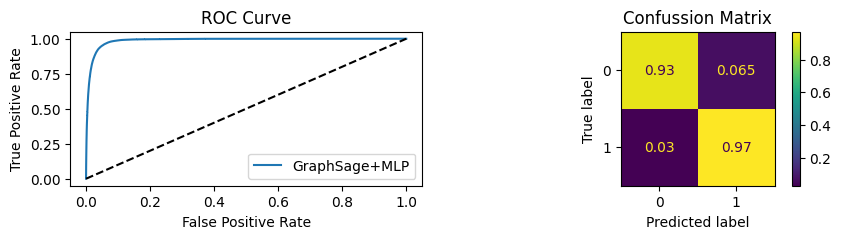

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 121: loss: 0.26746
Sensitivity (poss_acc):0.9713 Specificity (negative_acc):0.9291 accuracy:0.9502
Replacing models: GraphSage_epoch_106.pt  link_predictor_epoch_106.pt
with: Best models at GraphSage_epoch_121.pt  link_predictor_epoch_121.pt
Saving Model in Path GraphSage_epoch_121.pt
Saving Model in Path link_predictor_epoch_121.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 122: loss: 0.26705
Sensitivity (poss_acc):0.9706 Specificity (negative_acc):0.9299 accuracy:0.9503
Replacing models: GraphSage_epoch_121.pt  link_predictor_epoch_121.pt
with: Best models at GraphSage_epoch_122.pt  link_predictor_epoch_122.pt
Saving Model in Path GraphSage_epoch_122.pt
Saving Model in Path link_predictor_epoch_122.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 123: loss: 0.26473
Sensitivity (poss_acc):0.9635 Specificity (negative_acc):0.9346 accuracy:0.9490


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 124: loss: 0.26504
Sensitivity (poss_acc):0.9627 Specificity (negative_acc):0.9380 accuracy:0.9503
Replacing models: GraphSage_epoch_122.pt  link_predictor_epoch_122.pt
with: Best models at GraphSage_epoch_124.pt  link_predictor_epoch_124.pt
Saving Model in Path GraphSage_epoch_124.pt
Saving Model in Path link_predictor_epoch_124.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 125: loss: 0.26607
Sensitivity (poss_acc):0.9666 Specificity (negative_acc):0.9354 accuracy:0.9510
Replacing models: GraphSage_epoch_124.pt  link_predictor_epoch_124.pt
with: Best models at GraphSage_epoch_125.pt  link_predictor_epoch_125.pt
Saving Model in Path GraphSage_epoch_125.pt
Saving Model in Path link_predictor_epoch_125.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 126: loss: 0.26411
Sensitivity (poss_acc):0.9678 Specificity (negative_acc):0.9334 accuracy:0.9506


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 127: loss: 0.26382
Sensitivity (poss_acc):0.9671 Specificity (negative_acc):0.9317 accuracy:0.9494


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 128: loss: 0.26313
Sensitivity (poss_acc):0.9704 Specificity (negative_acc):0.9311 accuracy:0.9508


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 129: loss: 0.26358
Sensitivity (poss_acc):0.9712 Specificity (negative_acc):0.9295 accuracy:0.9504


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 130: loss: 0.26289
Sensitivity (poss_acc):0.9657 Specificity (negative_acc):0.9339 accuracy:0.9498


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 131: loss: 0.26048
Sensitivity (poss_acc):0.9611 Specificity (negative_acc):0.9408 accuracy:0.9510


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 132: loss: 0.26253
Sensitivity (poss_acc):0.9662 Specificity (negative_acc):0.9358 accuracy:0.9510


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 133: loss: 0.26234
Sensitivity (poss_acc):0.9582 Specificity (negative_acc):0.9418 accuracy:0.9500


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 134: loss: 0.2623
Sensitivity (poss_acc):0.9598 Specificity (negative_acc):0.9374 accuracy:0.9486


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 135: loss: 0.26003
Sensitivity (poss_acc):0.9676 Specificity (negative_acc):0.9375 accuracy:0.9526
Replacing models: GraphSage_epoch_125.pt  link_predictor_epoch_125.pt
with: Best models at GraphSage_epoch_135.pt  link_predictor_epoch_135.pt
Saving Model in Path GraphSage_epoch_135.pt
Saving Model in Path link_predictor_epoch_135.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 136: loss: 0.25959
Sensitivity (poss_acc):0.9656 Specificity (negative_acc):0.9367 accuracy:0.9512


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 137: loss: 0.25907
Sensitivity (poss_acc):0.9725 Specificity (negative_acc):0.9318 accuracy:0.9522


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 138: loss: 0.25993
Sensitivity (poss_acc):0.9653 Specificity (negative_acc):0.9386 accuracy:0.9520


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 139: loss: 0.25859
Sensitivity (poss_acc):0.9628 Specificity (negative_acc):0.9399 accuracy:0.9514


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 140: loss: 0.2587
Youdens  index: 0.4477 Sensitivity: 0.9686 Specificity: 0.9393


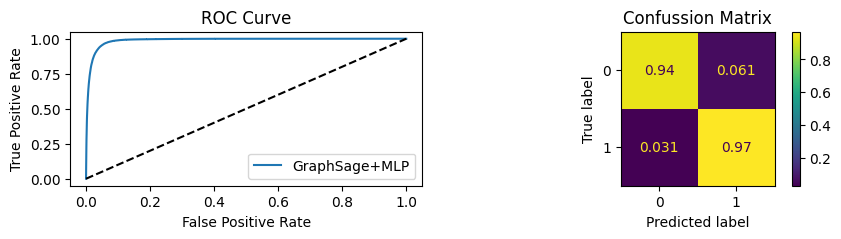

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 141: loss: 0.25835
Sensitivity (poss_acc):0.9592 Specificity (negative_acc):0.9428 accuracy:0.9510


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 142: loss: 0.25951
Sensitivity (poss_acc):0.9607 Specificity (negative_acc):0.9415 accuracy:0.9511


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 143: loss: 0.25619
Sensitivity (poss_acc):0.9679 Specificity (negative_acc):0.9357 accuracy:0.9518


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 144: loss: 0.2565
Sensitivity (poss_acc):0.9712 Specificity (negative_acc):0.9344 accuracy:0.9528
Replacing models: GraphSage_epoch_135.pt  link_predictor_epoch_135.pt
with: Best models at GraphSage_epoch_144.pt  link_predictor_epoch_144.pt
Saving Model in Path GraphSage_epoch_144.pt
Saving Model in Path link_predictor_epoch_144.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 145: loss: 0.25768
Sensitivity (poss_acc):0.9683 Specificity (negative_acc):0.9332 accuracy:0.9507


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 146: loss: 0.25658
Sensitivity (poss_acc):0.9678 Specificity (negative_acc):0.9369 accuracy:0.9523


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 147: loss: 0.25768
Sensitivity (poss_acc):0.9589 Specificity (negative_acc):0.9424 accuracy:0.9506


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 148: loss: 0.25606
Sensitivity (poss_acc):0.9607 Specificity (negative_acc):0.9430 accuracy:0.9519


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 149: loss: 0.25651
Sensitivity (poss_acc):0.9655 Specificity (negative_acc):0.9389 accuracy:0.9522


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 150: loss: 0.25521
Sensitivity (poss_acc):0.9692 Specificity (negative_acc):0.9355 accuracy:0.9523


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 151: loss: 0.25359
Sensitivity (poss_acc):0.9648 Specificity (negative_acc):0.9392 accuracy:0.9520


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 152: loss: 0.25417
Sensitivity (poss_acc):0.9650 Specificity (negative_acc):0.9409 accuracy:0.9530
Replacing models: GraphSage_epoch_144.pt  link_predictor_epoch_144.pt
with: Best models at GraphSage_epoch_152.pt  link_predictor_epoch_152.pt
Saving Model in Path GraphSage_epoch_152.pt
Saving Model in Path link_predictor_epoch_152.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 153: loss: 0.25302
Sensitivity (poss_acc):0.9635 Specificity (negative_acc):0.9410 accuracy:0.9523


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 154: loss: 0.2537
Sensitivity (poss_acc):0.9665 Specificity (negative_acc):0.9377 accuracy:0.9521


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 155: loss: 0.25221
Sensitivity (poss_acc):0.9675 Specificity (negative_acc):0.9381 accuracy:0.9528


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 156: loss: 0.25242
Sensitivity (poss_acc):0.9675 Specificity (negative_acc):0.9384 accuracy:0.9530


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 157: loss: 0.25123
Sensitivity (poss_acc):0.9666 Specificity (negative_acc):0.9392 accuracy:0.9529


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 158: loss: 0.25296
Sensitivity (poss_acc):0.9661 Specificity (negative_acc):0.9389 accuracy:0.9525


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 159: loss: 0.25249
Sensitivity (poss_acc):0.9681 Specificity (negative_acc):0.9368 accuracy:0.9525


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 160: loss: 0.25297
Youdens  index: 0.4759 Sensitivity: 0.9713 Specificity: 0.9409


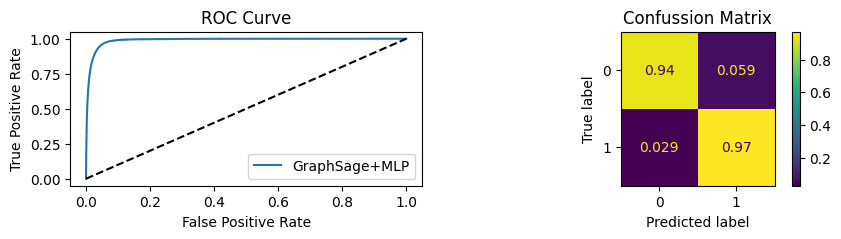

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 161: loss: 0.2519
Sensitivity (poss_acc):0.9630 Specificity (negative_acc):0.9417 accuracy:0.9523


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 162: loss: 0.25106
Sensitivity (poss_acc):0.9665 Specificity (negative_acc):0.9383 accuracy:0.9524


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 163: loss: 0.24998
Sensitivity (poss_acc):0.9701 Specificity (negative_acc):0.9353 accuracy:0.9527


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 164: loss: 0.25
Sensitivity (poss_acc):0.9733 Specificity (negative_acc):0.9346 accuracy:0.9539
Replacing models: GraphSage_epoch_152.pt  link_predictor_epoch_152.pt
with: Best models at GraphSage_epoch_164.pt  link_predictor_epoch_164.pt
Saving Model in Path GraphSage_epoch_164.pt
Saving Model in Path link_predictor_epoch_164.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 165: loss: 0.24976
Sensitivity (poss_acc):0.9711 Specificity (negative_acc):0.9358 accuracy:0.9534


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 166: loss: 0.24973
Sensitivity (poss_acc):0.9688 Specificity (negative_acc):0.9375 accuracy:0.9532


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 167: loss: 0.24891
Sensitivity (poss_acc):0.9593 Specificity (negative_acc):0.9413 accuracy:0.9503


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 168: loss: 0.25014
Sensitivity (poss_acc):0.9610 Specificity (negative_acc):0.9418 accuracy:0.9514


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 169: loss: 0.24934
Sensitivity (poss_acc):0.9579 Specificity (negative_acc):0.9433 accuracy:0.9506


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 170: loss: 0.24959
Sensitivity (poss_acc):0.9614 Specificity (negative_acc):0.9430 accuracy:0.9522


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 171: loss: 0.24784
Sensitivity (poss_acc):0.9668 Specificity (negative_acc):0.9391 accuracy:0.9529


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 172: loss: 0.24742
Sensitivity (poss_acc):0.9697 Specificity (negative_acc):0.9385 accuracy:0.9541
Replacing models: GraphSage_epoch_164.pt  link_predictor_epoch_164.pt
with: Best models at GraphSage_epoch_172.pt  link_predictor_epoch_172.pt
Saving Model in Path GraphSage_epoch_172.pt
Saving Model in Path link_predictor_epoch_172.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 173: loss: 0.24617
Sensitivity (poss_acc):0.9665 Specificity (negative_acc):0.9396 accuracy:0.9530


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 174: loss: 0.24688
Sensitivity (poss_acc):0.9692 Specificity (negative_acc):0.9388 accuracy:0.9540


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 175: loss: 0.24659
Sensitivity (poss_acc):0.9646 Specificity (negative_acc):0.9409 accuracy:0.9527


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 176: loss: 0.24533
Sensitivity (poss_acc):0.9636 Specificity (negative_acc):0.9417 accuracy:0.9527


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 177: loss: 0.24637
Sensitivity (poss_acc):0.9575 Specificity (negative_acc):0.9451 accuracy:0.9513


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 178: loss: 0.24636
Sensitivity (poss_acc):0.9605 Specificity (negative_acc):0.9447 accuracy:0.9526


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 179: loss: 0.24417
Sensitivity (poss_acc):0.9625 Specificity (negative_acc):0.9436 accuracy:0.9531


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 180: loss: 0.24339
Youdens  index: 0.5096 Sensitivity: 0.9723 Specificity: 0.9416


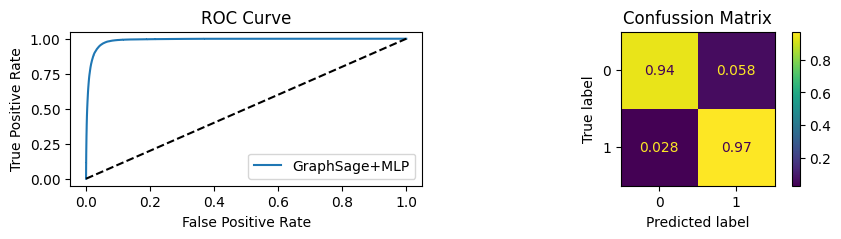

Replacing models: GraphSage_epoch_172.pt  link_predictor_epoch_172.pt
with: Best models at GraphSage_epoch_180.pt  link_predictor_epoch_180.pt
Saving Model in Path GraphSage_epoch_180.pt
Saving Model in Path link_predictor_epoch_180.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 181: loss: 0.24476
Sensitivity (poss_acc):0.9733 Specificity (negative_acc):0.9340 accuracy:0.9537


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 182: loss: 0.24473
Sensitivity (poss_acc):0.9679 Specificity (negative_acc):0.9384 accuracy:0.9532


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 183: loss: 0.24361
Sensitivity (poss_acc):0.9618 Specificity (negative_acc):0.9428 accuracy:0.9523


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 184: loss: 0.24319
Sensitivity (poss_acc):0.9600 Specificity (negative_acc):0.9451 accuracy:0.9525


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 185: loss: 0.24338
Sensitivity (poss_acc):0.9644 Specificity (negative_acc):0.9437 accuracy:0.9541


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 186: loss: 0.24115
Sensitivity (poss_acc):0.9657 Specificity (negative_acc):0.9401 accuracy:0.9529


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 187: loss: 0.24155
Sensitivity (poss_acc):0.9707 Specificity (negative_acc):0.9391 accuracy:0.9549
Replacing models: GraphSage_epoch_180.pt  link_predictor_epoch_180.pt
with: Best models at GraphSage_epoch_187.pt  link_predictor_epoch_187.pt
Saving Model in Path GraphSage_epoch_187.pt
Saving Model in Path link_predictor_epoch_187.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 188: loss: 0.24205
Sensitivity (poss_acc):0.9733 Specificity (negative_acc):0.9372 accuracy:0.9552
Replacing models: GraphSage_epoch_187.pt  link_predictor_epoch_187.pt
with: Best models at GraphSage_epoch_188.pt  link_predictor_epoch_188.pt
Saving Model in Path GraphSage_epoch_188.pt
Saving Model in Path link_predictor_epoch_188.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 189: loss: 0.24077
Sensitivity (poss_acc):0.9683 Specificity (negative_acc):0.9399 accuracy:0.9541


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 190: loss: 0.24113
Sensitivity (poss_acc):0.9685 Specificity (negative_acc):0.9392 accuracy:0.9539


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 191: loss: 0.23927
Sensitivity (poss_acc):0.9672 Specificity (negative_acc):0.9406 accuracy:0.9539


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 192: loss: 0.24036
Sensitivity (poss_acc):0.9645 Specificity (negative_acc):0.9435 accuracy:0.9540


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 193: loss: 0.2394
Sensitivity (poss_acc):0.9673 Specificity (negative_acc):0.9409 accuracy:0.9541


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 194: loss: 0.23914
Sensitivity (poss_acc):0.9675 Specificity (negative_acc):0.9411 accuracy:0.9543


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 195: loss: 0.23861
Sensitivity (poss_acc):0.9673 Specificity (negative_acc):0.9416 accuracy:0.9544


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 196: loss: 0.23896
Sensitivity (poss_acc):0.9726 Specificity (negative_acc):0.9379 accuracy:0.9553
Replacing models: GraphSage_epoch_188.pt  link_predictor_epoch_188.pt
with: Best models at GraphSage_epoch_196.pt  link_predictor_epoch_196.pt
Saving Model in Path GraphSage_epoch_196.pt
Saving Model in Path link_predictor_epoch_196.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 197: loss: 0.23795
Sensitivity (poss_acc):0.9667 Specificity (negative_acc):0.9429 accuracy:0.9548


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 198: loss: 0.23823
Sensitivity (poss_acc):0.9705 Specificity (negative_acc):0.9399 accuracy:0.9552


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 199: loss: 0.23664
Sensitivity (poss_acc):0.9672 Specificity (negative_acc):0.9417 accuracy:0.9544


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 200: loss: 0.23676
Youdens  index: 0.5023 Sensitivity: 0.9752 Specificity: 0.9413


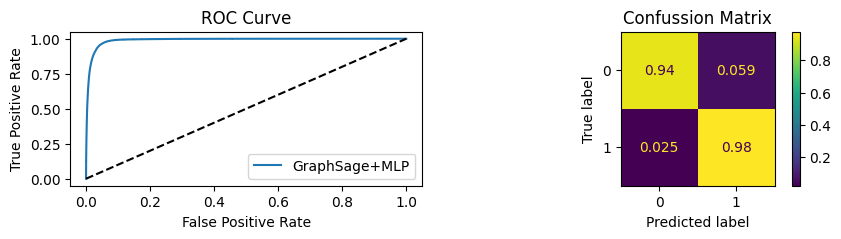

Replacing models: GraphSage_epoch_196.pt  link_predictor_epoch_196.pt
with: Best models at GraphSage_epoch_200.pt  link_predictor_epoch_200.pt
Saving Model in Path GraphSage_epoch_200.pt
Saving Model in Path link_predictor_epoch_200.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 201: loss: 0.23644
Sensitivity (poss_acc):0.9697 Specificity (negative_acc):0.9417 accuracy:0.9557
Replacing models: GraphSage_epoch_200.pt  link_predictor_epoch_200.pt
with: Best models at GraphSage_epoch_201.pt  link_predictor_epoch_201.pt
Saving Model in Path GraphSage_epoch_201.pt
Saving Model in Path link_predictor_epoch_201.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 202: loss: 0.23624
Sensitivity (poss_acc):0.9629 Specificity (negative_acc):0.9453 accuracy:0.9541


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 203: loss: 0.23554
Sensitivity (poss_acc):0.9639 Specificity (negative_acc):0.9465 accuracy:0.9552


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 204: loss: 0.23592
Sensitivity (poss_acc):0.9607 Specificity (negative_acc):0.9465 accuracy:0.9536


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 205: loss: 0.23655
Sensitivity (poss_acc):0.9685 Specificity (negative_acc):0.9453 accuracy:0.9569
Replacing models: GraphSage_epoch_201.pt  link_predictor_epoch_201.pt
with: Best models at GraphSage_epoch_205.pt  link_predictor_epoch_205.pt
Saving Model in Path GraphSage_epoch_205.pt
Saving Model in Path link_predictor_epoch_205.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 206: loss: 0.23618
Sensitivity (poss_acc):0.9686 Specificity (negative_acc):0.9403 accuracy:0.9545


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 207: loss: 0.23567
Sensitivity (poss_acc):0.9724 Specificity (negative_acc):0.9382 accuracy:0.9553


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 208: loss: 0.23635
Sensitivity (poss_acc):0.9734 Specificity (negative_acc):0.9370 accuracy:0.9552


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 209: loss: 0.23648
Sensitivity (poss_acc):0.9722 Specificity (negative_acc):0.9370 accuracy:0.9546


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 210: loss: 0.23571
Sensitivity (poss_acc):0.9658 Specificity (negative_acc):0.9442 accuracy:0.9550


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 211: loss: 0.23549
Sensitivity (poss_acc):0.9639 Specificity (negative_acc):0.9481 accuracy:0.9560


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 212: loss: 0.23367
Sensitivity (poss_acc):0.9685 Specificity (negative_acc):0.9404 accuracy:0.9544


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 213: loss: 0.23394
Sensitivity (poss_acc):0.9746 Specificity (negative_acc):0.9384 accuracy:0.9565


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 214: loss: 0.23312
Sensitivity (poss_acc):0.9648 Specificity (negative_acc):0.9472 accuracy:0.9560


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 215: loss: 0.23412
Sensitivity (poss_acc):0.9658 Specificity (negative_acc):0.9480 accuracy:0.9569


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 216: loss: 0.23404
Sensitivity (poss_acc):0.9707 Specificity (negative_acc):0.9427 accuracy:0.9567


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 217: loss: 0.23237
Sensitivity (poss_acc):0.9688 Specificity (negative_acc):0.9433 accuracy:0.9561


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 218: loss: 0.23169
Sensitivity (poss_acc):0.9664 Specificity (negative_acc):0.9450 accuracy:0.9557


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 219: loss: 0.23204
Sensitivity (poss_acc):0.9694 Specificity (negative_acc):0.9440 accuracy:0.9567


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 220: loss: 0.23084
Youdens  index: 0.5153 Sensitivity: 0.9693 Specificity: 0.949


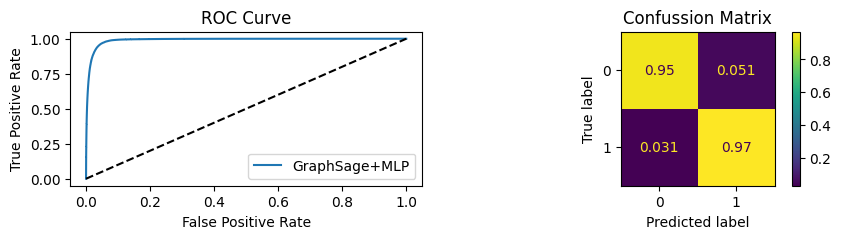

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 221: loss: 0.23039
Sensitivity (poss_acc):0.9659 Specificity (negative_acc):0.9454 accuracy:0.9557


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 222: loss: 0.22974
Sensitivity (poss_acc):0.9705 Specificity (negative_acc):0.9418 accuracy:0.9562


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 223: loss: 0.23239
Sensitivity (poss_acc):0.9678 Specificity (negative_acc):0.9458 accuracy:0.9568


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 224: loss: 0.22953
Sensitivity (poss_acc):0.9639 Specificity (negative_acc):0.9465 accuracy:0.9552


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 225: loss: 0.23109
Sensitivity (poss_acc):0.9726 Specificity (negative_acc):0.9450 accuracy:0.9588
Replacing models: GraphSage_epoch_205.pt  link_predictor_epoch_205.pt
with: Best models at GraphSage_epoch_225.pt  link_predictor_epoch_225.pt
Saving Model in Path GraphSage_epoch_225.pt
Saving Model in Path link_predictor_epoch_225.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 226: loss: 0.22909
Sensitivity (poss_acc):0.9628 Specificity (negative_acc):0.9505 accuracy:0.9566


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 227: loss: 0.22962
Sensitivity (poss_acc):0.9642 Specificity (negative_acc):0.9456 accuracy:0.9549


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 228: loss: 0.22821
Sensitivity (poss_acc):0.9650 Specificity (negative_acc):0.9464 accuracy:0.9557


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 229: loss: 0.22809
Sensitivity (poss_acc):0.9692 Specificity (negative_acc):0.9436 accuracy:0.9564


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 230: loss: 0.22909
Sensitivity (poss_acc):0.9680 Specificity (negative_acc):0.9461 accuracy:0.9570


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 231: loss: 0.22849
Sensitivity (poss_acc):0.9715 Specificity (negative_acc):0.9442 accuracy:0.9578


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 232: loss: 0.22809
Sensitivity (poss_acc):0.9653 Specificity (negative_acc):0.9472 accuracy:0.9562


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 233: loss: 0.22715
Sensitivity (poss_acc):0.9705 Specificity (negative_acc):0.9430 accuracy:0.9567


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 234: loss: 0.22826
Sensitivity (poss_acc):0.9611 Specificity (negative_acc):0.9489 accuracy:0.9550


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 235: loss: 0.22939
Sensitivity (poss_acc):0.9581 Specificity (negative_acc):0.9533 accuracy:0.9557


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 236: loss: 0.22788
Sensitivity (poss_acc):0.9595 Specificity (negative_acc):0.9513 accuracy:0.9554


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 237: loss: 0.22642
Sensitivity (poss_acc):0.9631 Specificity (negative_acc):0.9505 accuracy:0.9568


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 238: loss: 0.22636
Sensitivity (poss_acc):0.9678 Specificity (negative_acc):0.9454 accuracy:0.9566


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 239: loss: 0.22602
Sensitivity (poss_acc):0.9672 Specificity (negative_acc):0.9447 accuracy:0.9560


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 240: loss: 0.22611
Youdens  index: 0.4865 Sensitivity: 0.9721 Specificity: 0.9486


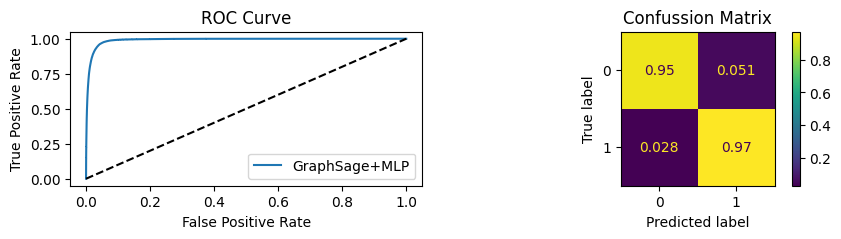

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 241: loss: 0.22561
Sensitivity (poss_acc):0.9617 Specificity (negative_acc):0.9491 accuracy:0.9554


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 242: loss: 0.2255
Sensitivity (poss_acc):0.9614 Specificity (negative_acc):0.9518 accuracy:0.9566


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 243: loss: 0.22539
Sensitivity (poss_acc):0.9653 Specificity (negative_acc):0.9478 accuracy:0.9565


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 244: loss: 0.22548
Sensitivity (poss_acc):0.9655 Specificity (negative_acc):0.9483 accuracy:0.9569


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 245: loss: 0.22434
Sensitivity (poss_acc):0.9679 Specificity (negative_acc):0.9478 accuracy:0.9578


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 246: loss: 0.22464
Sensitivity (poss_acc):0.9668 Specificity (negative_acc):0.9453 accuracy:0.9560


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 247: loss: 0.22402
Sensitivity (poss_acc):0.9659 Specificity (negative_acc):0.9495 accuracy:0.9577


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 248: loss: 0.22582
Sensitivity (poss_acc):0.9645 Specificity (negative_acc):0.9494 accuracy:0.9570


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 249: loss: 0.22449
Sensitivity (poss_acc):0.9645 Specificity (negative_acc):0.9502 accuracy:0.9573


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 250: loss: 0.22317
Sensitivity (poss_acc):0.9677 Specificity (negative_acc):0.9492 accuracy:0.9585


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 251: loss: 0.22275
Sensitivity (poss_acc):0.9643 Specificity (negative_acc):0.9498 accuracy:0.9571


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 252: loss: 0.22406
Sensitivity (poss_acc):0.9700 Specificity (negative_acc):0.9458 accuracy:0.9579


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 253: loss: 0.22284
Sensitivity (poss_acc):0.9649 Specificity (negative_acc):0.9497 accuracy:0.9573


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 254: loss: 0.2225
Sensitivity (poss_acc):0.9658 Specificity (negative_acc):0.9487 accuracy:0.9572


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 255: loss: 0.22201
Sensitivity (poss_acc):0.9649 Specificity (negative_acc):0.9520 accuracy:0.9584


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 256: loss: 0.22218
Sensitivity (poss_acc):0.9627 Specificity (negative_acc):0.9505 accuracy:0.9566


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 257: loss: 0.22251
Sensitivity (poss_acc):0.9720 Specificity (negative_acc):0.9460 accuracy:0.9590
Replacing models: GraphSage_epoch_225.pt  link_predictor_epoch_225.pt
with: Best models at GraphSage_epoch_257.pt  link_predictor_epoch_257.pt
Saving Model in Path GraphSage_epoch_257.pt
Saving Model in Path link_predictor_epoch_257.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 258: loss: 0.22205
Sensitivity (poss_acc):0.9747 Specificity (negative_acc):0.9416 accuracy:0.9581


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 259: loss: 0.22181
Sensitivity (poss_acc):0.9731 Specificity (negative_acc):0.9439 accuracy:0.9585


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 260: loss: 0.22241
Youdens  index: 0.4799 Sensitivity: 0.9742 Specificity: 0.9492


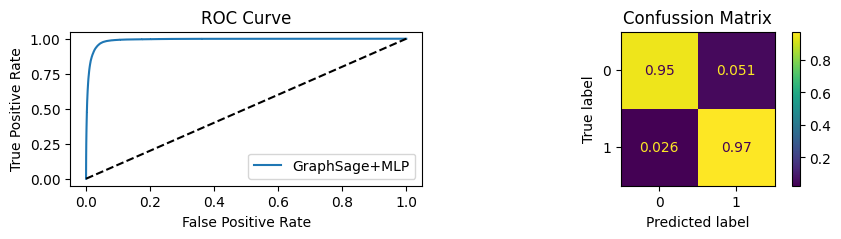

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 261: loss: 0.22188
Sensitivity (poss_acc):0.9650 Specificity (negative_acc):0.9515 accuracy:0.9582


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 262: loss: 0.22249
Sensitivity (poss_acc):0.9683 Specificity (negative_acc):0.9471 accuracy:0.9577


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 263: loss: 0.22099
Sensitivity (poss_acc):0.9705 Specificity (negative_acc):0.9476 accuracy:0.9591
Replacing models: GraphSage_epoch_257.pt  link_predictor_epoch_257.pt
with: Best models at GraphSage_epoch_263.pt  link_predictor_epoch_263.pt
Saving Model in Path GraphSage_epoch_263.pt
Saving Model in Path link_predictor_epoch_263.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 264: loss: 0.22036
Sensitivity (poss_acc):0.9705 Specificity (negative_acc):0.9444 accuracy:0.9575


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 265: loss: 0.22
Sensitivity (poss_acc):0.9732 Specificity (negative_acc):0.9412 accuracy:0.9572


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 266: loss: 0.22151
Sensitivity (poss_acc):0.9746 Specificity (negative_acc):0.9426 accuracy:0.9586


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 267: loss: 0.21994
Sensitivity (poss_acc):0.9677 Specificity (negative_acc):0.9464 accuracy:0.9570


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 268: loss: 0.21927
Sensitivity (poss_acc):0.9663 Specificity (negative_acc):0.9492 accuracy:0.9578


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 269: loss: 0.21889
Sensitivity (poss_acc):0.9738 Specificity (negative_acc):0.9462 accuracy:0.9600
Replacing models: GraphSage_epoch_263.pt  link_predictor_epoch_263.pt
with: Best models at GraphSage_epoch_269.pt  link_predictor_epoch_269.pt
Saving Model in Path GraphSage_epoch_269.pt
Saving Model in Path link_predictor_epoch_269.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 270: loss: 0.21817
Sensitivity (poss_acc):0.9719 Specificity (negative_acc):0.9442 accuracy:0.9581


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 271: loss: 0.21906
Sensitivity (poss_acc):0.9772 Specificity (negative_acc):0.9410 accuracy:0.9591


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 272: loss: 0.21907
Sensitivity (poss_acc):0.9761 Specificity (negative_acc):0.9422 accuracy:0.9592


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 273: loss: 0.21737
Sensitivity (poss_acc):0.9732 Specificity (negative_acc):0.9430 accuracy:0.9581


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 274: loss: 0.21879
Sensitivity (poss_acc):0.9741 Specificity (negative_acc):0.9427 accuracy:0.9584


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 275: loss: 0.21761
Sensitivity (poss_acc):0.9703 Specificity (negative_acc):0.9440 accuracy:0.9571


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 276: loss: 0.21725
Sensitivity (poss_acc):0.9744 Specificity (negative_acc):0.9453 accuracy:0.9598


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 277: loss: 0.21763
Sensitivity (poss_acc):0.9750 Specificity (negative_acc):0.9401 accuracy:0.9576


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 278: loss: 0.21655
Sensitivity (poss_acc):0.9748 Specificity (negative_acc):0.9417 accuracy:0.9583


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 279: loss: 0.21692
Sensitivity (poss_acc):0.9744 Specificity (negative_acc):0.9432 accuracy:0.9588


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 280: loss: 0.21707
Youdens  index: 0.4870 Sensitivity: 0.9747 Specificity: 0.9489


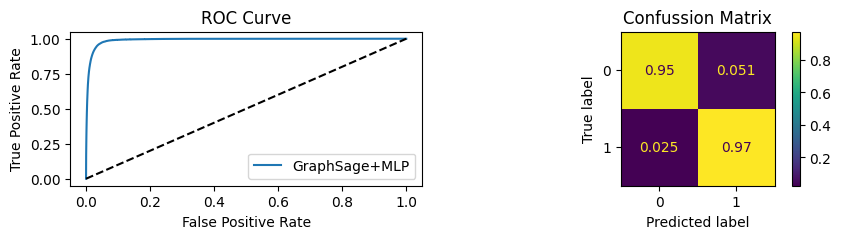

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 281: loss: 0.21581
Sensitivity (poss_acc):0.9759 Specificity (negative_acc):0.9430 accuracy:0.9595


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 282: loss: 0.21575
Sensitivity (poss_acc):0.9747 Specificity (negative_acc):0.9465 accuracy:0.9606
Replacing models: GraphSage_epoch_269.pt  link_predictor_epoch_269.pt
with: Best models at GraphSage_epoch_282.pt  link_predictor_epoch_282.pt
Saving Model in Path GraphSage_epoch_282.pt
Saving Model in Path link_predictor_epoch_282.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 283: loss: 0.21522
Sensitivity (poss_acc):0.9697 Specificity (negative_acc):0.9481 accuracy:0.9589


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 284: loss: 0.21528
Sensitivity (poss_acc):0.9723 Specificity (negative_acc):0.9448 accuracy:0.9586


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 285: loss: 0.21564
Sensitivity (poss_acc):0.9730 Specificity (negative_acc):0.9459 accuracy:0.9595


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 286: loss: 0.21486
Sensitivity (poss_acc):0.9712 Specificity (negative_acc):0.9479 accuracy:0.9596


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 287: loss: 0.21505
Sensitivity (poss_acc):0.9711 Specificity (negative_acc):0.9481 accuracy:0.9596


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 288: loss: 0.21424
Sensitivity (poss_acc):0.9706 Specificity (negative_acc):0.9481 accuracy:0.9593


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 289: loss: 0.21409
Sensitivity (poss_acc):0.9672 Specificity (negative_acc):0.9498 accuracy:0.9585


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 290: loss: 0.21369
Sensitivity (poss_acc):0.9708 Specificity (negative_acc):0.9477 accuracy:0.9592


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 291: loss: 0.21472
Sensitivity (poss_acc):0.9664 Specificity (negative_acc):0.9508 accuracy:0.9586


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 292: loss: 0.21233
Sensitivity (poss_acc):0.9671 Specificity (negative_acc):0.9530 accuracy:0.9601


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 293: loss: 0.21278
Sensitivity (poss_acc):0.9678 Specificity (negative_acc):0.9514 accuracy:0.9596


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 294: loss: 0.21261
Sensitivity (poss_acc):0.9688 Specificity (negative_acc):0.9517 accuracy:0.9603


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 295: loss: 0.21339
Sensitivity (poss_acc):0.9711 Specificity (negative_acc):0.9516 accuracy:0.9613
Replacing models: GraphSage_epoch_282.pt  link_predictor_epoch_282.pt
with: Best models at GraphSage_epoch_295.pt  link_predictor_epoch_295.pt
Saving Model in Path GraphSage_epoch_295.pt
Saving Model in Path link_predictor_epoch_295.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 296: loss: 0.21351
Sensitivity (poss_acc):0.9625 Specificity (negative_acc):0.9554 accuracy:0.9590


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 297: loss: 0.21278
Sensitivity (poss_acc):0.9636 Specificity (negative_acc):0.9537 accuracy:0.9586


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 298: loss: 0.21269
Sensitivity (poss_acc):0.9657 Specificity (negative_acc):0.9523 accuracy:0.9590


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 299: loss: 0.21247
Sensitivity (poss_acc):0.9627 Specificity (negative_acc):0.9550 accuracy:0.9588


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 300: loss: 0.21307
Youdens  index: 0.3577 Sensitivity: 0.9738 Specificity: 0.9497


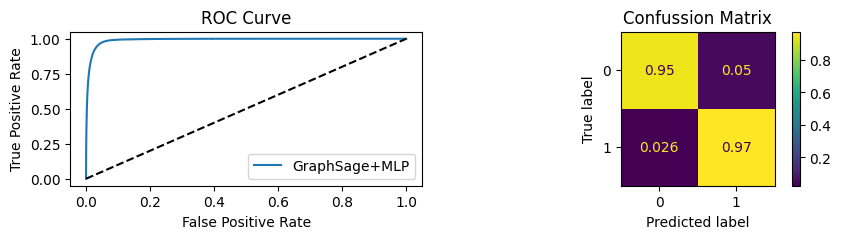

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 301: loss: 0.21402
Sensitivity (poss_acc):0.9637 Specificity (negative_acc):0.9521 accuracy:0.9579


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 302: loss: 0.21325
Sensitivity (poss_acc):0.9626 Specificity (negative_acc):0.9561 accuracy:0.9593


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 303: loss: 0.21278
Sensitivity (poss_acc):0.9653 Specificity (negative_acc):0.9530 accuracy:0.9591


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 304: loss: 0.21161
Sensitivity (poss_acc):0.9665 Specificity (negative_acc):0.9531 accuracy:0.9598


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 305: loss: 0.21247
Sensitivity (poss_acc):0.9650 Specificity (negative_acc):0.9538 accuracy:0.9594


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 306: loss: 0.21106
Sensitivity (poss_acc):0.9659 Specificity (negative_acc):0.9532 accuracy:0.9596


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 307: loss: 0.21065
Sensitivity (poss_acc):0.9663 Specificity (negative_acc):0.9521 accuracy:0.9592


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 308: loss: 0.21241
Sensitivity (poss_acc):0.9669 Specificity (negative_acc):0.9523 accuracy:0.9596


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 309: loss: 0.20996
Sensitivity (poss_acc):0.9691 Specificity (negative_acc):0.9495 accuracy:0.9593


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 310: loss: 0.21213
Sensitivity (poss_acc):0.9702 Specificity (negative_acc):0.9500 accuracy:0.9601


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 311: loss: 0.20918
Sensitivity (poss_acc):0.9701 Specificity (negative_acc):0.9494 accuracy:0.9598


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 312: loss: 0.2106
Sensitivity (poss_acc):0.9728 Specificity (negative_acc):0.9470 accuracy:0.9599


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 313: loss: 0.20985
Sensitivity (poss_acc):0.9687 Specificity (negative_acc):0.9494 accuracy:0.9590


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 314: loss: 0.20881
Sensitivity (poss_acc):0.9737 Specificity (negative_acc):0.9449 accuracy:0.9593


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 315: loss: 0.21073
Sensitivity (poss_acc):0.9741 Specificity (negative_acc):0.9460 accuracy:0.9600


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 316: loss: 0.21061
Sensitivity (poss_acc):0.9765 Specificity (negative_acc):0.9438 accuracy:0.9601


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 317: loss: 0.20999
Sensitivity (poss_acc):0.9723 Specificity (negative_acc):0.9476 accuracy:0.9599


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 318: loss: 0.2099
Sensitivity (poss_acc):0.9768 Specificity (negative_acc):0.9436 accuracy:0.9602


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 319: loss: 0.2097
Sensitivity (poss_acc):0.9704 Specificity (negative_acc):0.9469 accuracy:0.9586


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 320: loss: 0.20922
Youdens  index: 0.4909 Sensitivity: 0.9772 Specificity: 0.9516


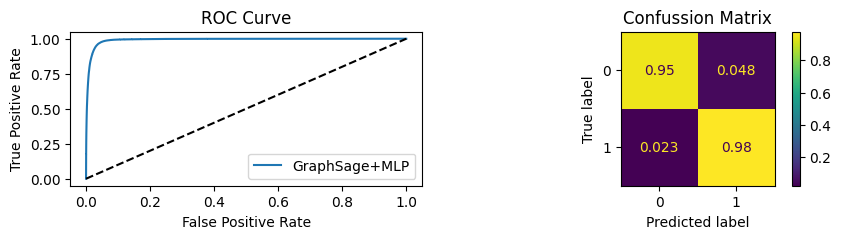

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 321: loss: 0.20826
Sensitivity (poss_acc):0.9720 Specificity (negative_acc):0.9496 accuracy:0.9608


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 322: loss: 0.20878
Sensitivity (poss_acc):0.9720 Specificity (negative_acc):0.9477 accuracy:0.9598


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 323: loss: 0.20727
Sensitivity (poss_acc):0.9706 Specificity (negative_acc):0.9498 accuracy:0.9602


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 324: loss: 0.20753
Sensitivity (poss_acc):0.9725 Specificity (negative_acc):0.9468 accuracy:0.9596


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 325: loss: 0.20692
Sensitivity (poss_acc):0.9701 Specificity (negative_acc):0.9519 accuracy:0.9610


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 326: loss: 0.20675
Sensitivity (poss_acc):0.9702 Specificity (negative_acc):0.9484 accuracy:0.9593


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 327: loss: 0.20595
Sensitivity (poss_acc):0.9690 Specificity (negative_acc):0.9511 accuracy:0.9601


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 328: loss: 0.20712
Sensitivity (poss_acc):0.9677 Specificity (negative_acc):0.9513 accuracy:0.9595


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 329: loss: 0.20739
Sensitivity (poss_acc):0.9684 Specificity (negative_acc):0.9531 accuracy:0.9608


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 330: loss: 0.20584
Sensitivity (poss_acc):0.9688 Specificity (negative_acc):0.9528 accuracy:0.9608


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 331: loss: 0.20628
Sensitivity (poss_acc):0.9657 Specificity (negative_acc):0.9528 accuracy:0.9593


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 332: loss: 0.20577
Sensitivity (poss_acc):0.9656 Specificity (negative_acc):0.9554 accuracy:0.9605


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 333: loss: 0.2068
Sensitivity (poss_acc):0.9600 Specificity (negative_acc):0.9546 accuracy:0.9573


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 334: loss: 0.20637
Sensitivity (poss_acc):0.9603 Specificity (negative_acc):0.9579 accuracy:0.9591


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 335: loss: 0.20603
Sensitivity (poss_acc):0.9650 Specificity (negative_acc):0.9583 accuracy:0.9616
Replacing models: GraphSage_epoch_295.pt  link_predictor_epoch_295.pt
with: Best models at GraphSage_epoch_335.pt  link_predictor_epoch_335.pt
Saving Model in Path GraphSage_epoch_335.pt
Saving Model in Path link_predictor_epoch_335.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 336: loss: 0.20651
Sensitivity (poss_acc):0.9687 Specificity (negative_acc):0.9551 accuracy:0.9619
Replacing models: GraphSage_epoch_335.pt  link_predictor_epoch_335.pt
with: Best models at GraphSage_epoch_336.pt  link_predictor_epoch_336.pt
Saving Model in Path GraphSage_epoch_336.pt
Saving Model in Path link_predictor_epoch_336.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 337: loss: 0.20471
Sensitivity (poss_acc):0.9646 Specificity (negative_acc):0.9545 accuracy:0.9595


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 338: loss: 0.20495
Sensitivity (poss_acc):0.9644 Specificity (negative_acc):0.9562 accuracy:0.9603


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 339: loss: 0.20538
Sensitivity (poss_acc):0.9657 Specificity (negative_acc):0.9574 accuracy:0.9615


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 340: loss: 0.2047
Youdens  index: 0.4264 Sensitivity: 0.975 Specificity: 0.953


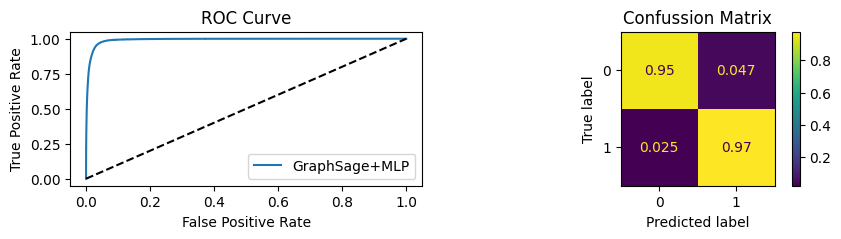

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 341: loss: 0.20435
Sensitivity (poss_acc):0.9666 Specificity (negative_acc):0.9557 accuracy:0.9611


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 342: loss: 0.20373
Sensitivity (poss_acc):0.9670 Specificity (negative_acc):0.9543 accuracy:0.9606


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 343: loss: 0.20429
Sensitivity (poss_acc):0.9682 Specificity (negative_acc):0.9543 accuracy:0.9612


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 344: loss: 0.20451
Sensitivity (poss_acc):0.9678 Specificity (negative_acc):0.9537 accuracy:0.9608


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 345: loss: 0.20414
Sensitivity (poss_acc):0.9675 Specificity (negative_acc):0.9504 accuracy:0.9590


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 346: loss: 0.20439
Sensitivity (poss_acc):0.9697 Specificity (negative_acc):0.9545 accuracy:0.9621
Replacing models: GraphSage_epoch_336.pt  link_predictor_epoch_336.pt
with: Best models at GraphSage_epoch_346.pt  link_predictor_epoch_346.pt
Saving Model in Path GraphSage_epoch_346.pt
Saving Model in Path link_predictor_epoch_346.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 347: loss: 0.20308
Sensitivity (poss_acc):0.9701 Specificity (negative_acc):0.9547 accuracy:0.9624
Replacing models: GraphSage_epoch_346.pt  link_predictor_epoch_346.pt
with: Best models at GraphSage_epoch_347.pt  link_predictor_epoch_347.pt
Saving Model in Path GraphSage_epoch_347.pt
Saving Model in Path link_predictor_epoch_347.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 348: loss: 0.20318
Sensitivity (poss_acc):0.9689 Specificity (negative_acc):0.9515 accuracy:0.9602


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 349: loss: 0.20354
Sensitivity (poss_acc):0.9701 Specificity (negative_acc):0.9538 accuracy:0.9620


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 350: loss: 0.20277
Sensitivity (poss_acc):0.9727 Specificity (negative_acc):0.9515 accuracy:0.9621


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 351: loss: 0.20217
Sensitivity (poss_acc):0.9716 Specificity (negative_acc):0.9517 accuracy:0.9616


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 352: loss: 0.2018
Sensitivity (poss_acc):0.9710 Specificity (negative_acc):0.9509 accuracy:0.9609


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 353: loss: 0.20228
Sensitivity (poss_acc):0.9756 Specificity (negative_acc):0.9489 accuracy:0.9622


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 354: loss: 0.20235
Sensitivity (poss_acc):0.9758 Specificity (negative_acc):0.9475 accuracy:0.9617


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 355: loss: 0.20168
Sensitivity (poss_acc):0.9700 Specificity (negative_acc):0.9525 accuracy:0.9613


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 356: loss: 0.20149
Sensitivity (poss_acc):0.9727 Specificity (negative_acc):0.9485 accuracy:0.9606


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 357: loss: 0.20179
Sensitivity (poss_acc):0.9720 Specificity (negative_acc):0.9525 accuracy:0.9622


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 358: loss: 0.20192
Sensitivity (poss_acc):0.9791 Specificity (negative_acc):0.9421 accuracy:0.9606


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 359: loss: 0.20239
Sensitivity (poss_acc):0.9766 Specificity (negative_acc):0.9425 accuracy:0.9596


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 360: loss: 0.20231
Youdens  index: 0.4987 Sensitivity: 0.9778 Specificity: 0.953


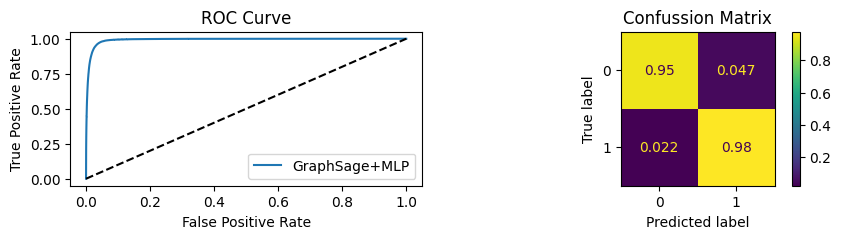

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 361: loss: 0.20138
Sensitivity (poss_acc):0.9729 Specificity (negative_acc):0.9515 accuracy:0.9622


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 362: loss: 0.20026
Sensitivity (poss_acc):0.9731 Specificity (negative_acc):0.9519 accuracy:0.9625
Replacing models: GraphSage_epoch_347.pt  link_predictor_epoch_347.pt
with: Best models at GraphSage_epoch_362.pt  link_predictor_epoch_362.pt
Saving Model in Path GraphSage_epoch_362.pt
Saving Model in Path link_predictor_epoch_362.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 363: loss: 0.20056
Sensitivity (poss_acc):0.9739 Specificity (negative_acc):0.9518 accuracy:0.9629
Replacing models: GraphSage_epoch_362.pt  link_predictor_epoch_362.pt
with: Best models at GraphSage_epoch_363.pt  link_predictor_epoch_363.pt
Saving Model in Path GraphSage_epoch_363.pt
Saving Model in Path link_predictor_epoch_363.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 364: loss: 0.1995
Sensitivity (poss_acc):0.9752 Specificity (negative_acc):0.9480 accuracy:0.9616


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 365: loss: 0.19938
Sensitivity (poss_acc):0.9774 Specificity (negative_acc):0.9496 accuracy:0.9635
Replacing models: GraphSage_epoch_363.pt  link_predictor_epoch_363.pt
with: Best models at GraphSage_epoch_365.pt  link_predictor_epoch_365.pt
Saving Model in Path GraphSage_epoch_365.pt
Saving Model in Path link_predictor_epoch_365.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 366: loss: 0.19918
Sensitivity (poss_acc):0.9706 Specificity (negative_acc):0.9548 accuracy:0.9627


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 367: loss: 0.20041
Sensitivity (poss_acc):0.9700 Specificity (negative_acc):0.9526 accuracy:0.9613


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 368: loss: 0.19937
Sensitivity (poss_acc):0.9716 Specificity (negative_acc):0.9528 accuracy:0.9622


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 369: loss: 0.19937
Sensitivity (poss_acc):0.9694 Specificity (negative_acc):0.9542 accuracy:0.9618


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 370: loss: 0.19841
Sensitivity (poss_acc):0.9716 Specificity (negative_acc):0.9549 accuracy:0.9633


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 371: loss: 0.1983
Sensitivity (poss_acc):0.9686 Specificity (negative_acc):0.9563 accuracy:0.9624


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 372: loss: 0.19986
Sensitivity (poss_acc):0.9707 Specificity (negative_acc):0.9542 accuracy:0.9625


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 373: loss: 0.19817
Sensitivity (poss_acc):0.9686 Specificity (negative_acc):0.9567 accuracy:0.9627


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 374: loss: 0.19857
Sensitivity (poss_acc):0.9693 Specificity (negative_acc):0.9559 accuracy:0.9626


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 375: loss: 0.19845
Sensitivity (poss_acc):0.9701 Specificity (negative_acc):0.9578 accuracy:0.9640
Replacing models: GraphSage_epoch_365.pt  link_predictor_epoch_365.pt
with: Best models at GraphSage_epoch_375.pt  link_predictor_epoch_375.pt
Saving Model in Path GraphSage_epoch_375.pt
Saving Model in Path link_predictor_epoch_375.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 376: loss: 0.19775
Sensitivity (poss_acc):0.9709 Specificity (negative_acc):0.9565 accuracy:0.9637


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 377: loss: 0.19733
Sensitivity (poss_acc):0.9701 Specificity (negative_acc):0.9573 accuracy:0.9637


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 378: loss: 0.19814
Sensitivity (poss_acc):0.9683 Specificity (negative_acc):0.9558 accuracy:0.9621


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 379: loss: 0.19697
Sensitivity (poss_acc):0.9707 Specificity (negative_acc):0.9548 accuracy:0.9627


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 380: loss: 0.19703
Youdens  index: 0.4065 Sensitivity: 0.9759 Specificity: 0.9556


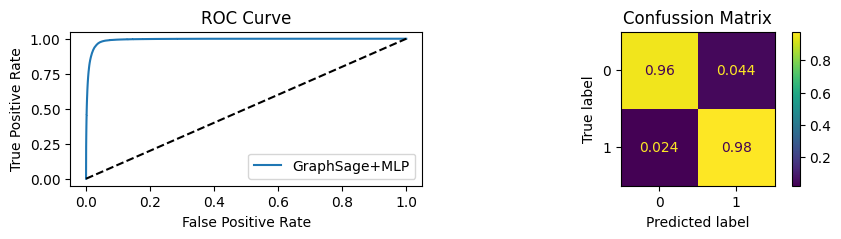

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 381: loss: 0.19613
Sensitivity (poss_acc):0.9692 Specificity (negative_acc):0.9575 accuracy:0.9634


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 382: loss: 0.19568
Sensitivity (poss_acc):0.9677 Specificity (negative_acc):0.9565 accuracy:0.9621


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 383: loss: 0.19671
Sensitivity (poss_acc):0.9720 Specificity (negative_acc):0.9552 accuracy:0.9636


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 384: loss: 0.19633
Sensitivity (poss_acc):0.9659 Specificity (negative_acc):0.9567 accuracy:0.9613


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 385: loss: 0.19643
Sensitivity (poss_acc):0.9650 Specificity (negative_acc):0.9579 accuracy:0.9614


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 386: loss: 0.19629
Sensitivity (poss_acc):0.9634 Specificity (negative_acc):0.9593 accuracy:0.9613


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 387: loss: 0.19717
Sensitivity (poss_acc):0.9650 Specificity (negative_acc):0.9577 accuracy:0.9613


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 388: loss: 0.19528
Sensitivity (poss_acc):0.9679 Specificity (negative_acc):0.9560 accuracy:0.9619


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 389: loss: 0.19578
Sensitivity (poss_acc):0.9688 Specificity (negative_acc):0.9555 accuracy:0.9621


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 390: loss: 0.19609
Sensitivity (poss_acc):0.9712 Specificity (negative_acc):0.9567 accuracy:0.9639


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 391: loss: 0.19454
Sensitivity (poss_acc):0.9690 Specificity (negative_acc):0.9582 accuracy:0.9636


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 392: loss: 0.1946
Sensitivity (poss_acc):0.9683 Specificity (negative_acc):0.9574 accuracy:0.9628


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 393: loss: 0.19447
Sensitivity (poss_acc):0.9676 Specificity (negative_acc):0.9591 accuracy:0.9634


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 394: loss: 0.19431
Sensitivity (poss_acc):0.9688 Specificity (negative_acc):0.9582 accuracy:0.9635


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 395: loss: 0.19462
Sensitivity (poss_acc):0.9713 Specificity (negative_acc):0.9563 accuracy:0.9638


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 396: loss: 0.19392
Sensitivity (poss_acc):0.9698 Specificity (negative_acc):0.9552 accuracy:0.9625


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 397: loss: 0.19483
Sensitivity (poss_acc):0.9709 Specificity (negative_acc):0.9557 accuracy:0.9633


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 398: loss: 0.19364
Sensitivity (poss_acc):0.9667 Specificity (negative_acc):0.9587 accuracy:0.9627


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 399: loss: 0.1944
Sensitivity (poss_acc):0.9683 Specificity (negative_acc):0.9585 accuracy:0.9634


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 400: loss: 0.19411
Youdens  index: 0.4374 Sensitivity: 0.9759 Specificity: 0.958


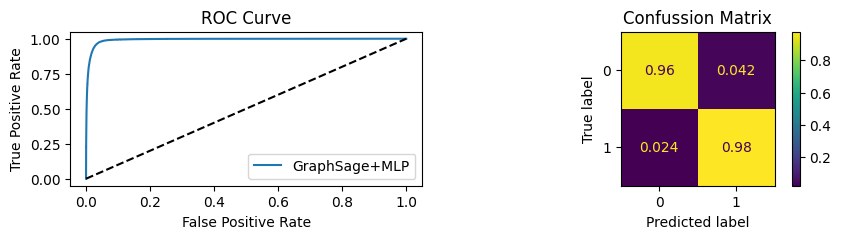

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 401: loss: 0.19273
Sensitivity (poss_acc):0.9664 Specificity (negative_acc):0.9589 accuracy:0.9626


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 402: loss: 0.19357
Sensitivity (poss_acc):0.9722 Specificity (negative_acc):0.9545 accuracy:0.9633


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 403: loss: 0.19384
Sensitivity (poss_acc):0.9701 Specificity (negative_acc):0.9551 accuracy:0.9626


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 404: loss: 0.19222
Sensitivity (poss_acc):0.9727 Specificity (negative_acc):0.9547 accuracy:0.9637


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 405: loss: 0.1927
Sensitivity (poss_acc):0.9709 Specificity (negative_acc):0.9563 accuracy:0.9636


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 406: loss: 0.19312
Sensitivity (poss_acc):0.9687 Specificity (negative_acc):0.9564 accuracy:0.9626


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 407: loss: 0.19304
Sensitivity (poss_acc):0.9698 Specificity (negative_acc):0.9555 accuracy:0.9626


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 408: loss: 0.19219
Sensitivity (poss_acc):0.9749 Specificity (negative_acc):0.9562 accuracy:0.9655
Replacing models: GraphSage_epoch_375.pt  link_predictor_epoch_375.pt
with: Best models at GraphSage_epoch_408.pt  link_predictor_epoch_408.pt
Saving Model in Path GraphSage_epoch_408.pt
Saving Model in Path link_predictor_epoch_408.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 409: loss: 0.19134
Sensitivity (poss_acc):0.9695 Specificity (negative_acc):0.9571 accuracy:0.9633


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 410: loss: 0.19221
Sensitivity (poss_acc):0.9744 Specificity (negative_acc):0.9518 accuracy:0.9631


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 411: loss: 0.19209
Sensitivity (poss_acc):0.9731 Specificity (negative_acc):0.9572 accuracy:0.9651


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 412: loss: 0.1917
Sensitivity (poss_acc):0.9727 Specificity (negative_acc):0.9555 accuracy:0.9641


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 413: loss: 0.19107
Sensitivity (poss_acc):0.9753 Specificity (negative_acc):0.9516 accuracy:0.9634


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 414: loss: 0.19225
Sensitivity (poss_acc):0.9753 Specificity (negative_acc):0.9536 accuracy:0.9645


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 415: loss: 0.19184
Sensitivity (poss_acc):0.9737 Specificity (negative_acc):0.9523 accuracy:0.9630


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 416: loss: 0.19166
Sensitivity (poss_acc):0.9743 Specificity (negative_acc):0.9549 accuracy:0.9646


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 417: loss: 0.19076
Sensitivity (poss_acc):0.9736 Specificity (negative_acc):0.9545 accuracy:0.9641


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 418: loss: 0.18988
Sensitivity (poss_acc):0.9718 Specificity (negative_acc):0.9533 accuracy:0.9625


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 419: loss: 0.19025
Sensitivity (poss_acc):0.9741 Specificity (negative_acc):0.9538 accuracy:0.9640


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 420: loss: 0.19116
Youdens  index: 0.5147 Sensitivity: 0.9744 Specificity: 0.9594


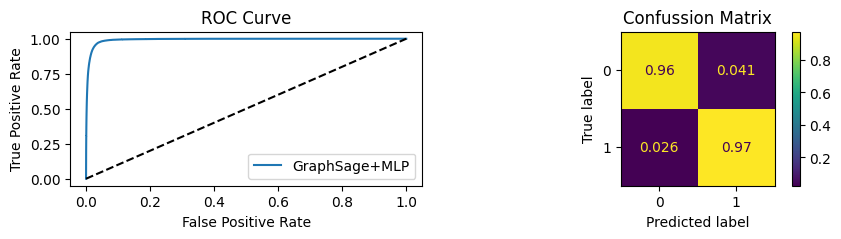

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 421: loss: 0.19016
Sensitivity (poss_acc):0.9730 Specificity (negative_acc):0.9543 accuracy:0.9637


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 422: loss: 0.18954
Sensitivity (poss_acc):0.9747 Specificity (negative_acc):0.9554 accuracy:0.9650


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 423: loss: 0.18887
Sensitivity (poss_acc):0.9770 Specificity (negative_acc):0.9518 accuracy:0.9644


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 424: loss: 0.19003
Sensitivity (poss_acc):0.9758 Specificity (negative_acc):0.9540 accuracy:0.9649


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 425: loss: 0.18987
Sensitivity (poss_acc):0.9768 Specificity (negative_acc):0.9537 accuracy:0.9653


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 426: loss: 0.18904
Sensitivity (poss_acc):0.9729 Specificity (negative_acc):0.9555 accuracy:0.9642


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 427: loss: 0.18941
Sensitivity (poss_acc):0.9700 Specificity (negative_acc):0.9568 accuracy:0.9634


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 428: loss: 0.19028
Sensitivity (poss_acc):0.9741 Specificity (negative_acc):0.9554 accuracy:0.9648


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 429: loss: 0.18873
Sensitivity (poss_acc):0.9738 Specificity (negative_acc):0.9584 accuracy:0.9661
Replacing models: GraphSage_epoch_408.pt  link_predictor_epoch_408.pt
with: Best models at GraphSage_epoch_429.pt  link_predictor_epoch_429.pt
Saving Model in Path GraphSage_epoch_429.pt
Saving Model in Path link_predictor_epoch_429.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 430: loss: 0.18876
Sensitivity (poss_acc):0.9693 Specificity (negative_acc):0.9581 accuracy:0.9637


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 431: loss: 0.18923
Sensitivity (poss_acc):0.9665 Specificity (negative_acc):0.9596 accuracy:0.9630


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 432: loss: 0.18875
Sensitivity (poss_acc):0.9698 Specificity (negative_acc):0.9588 accuracy:0.9643


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 433: loss: 0.18845
Sensitivity (poss_acc):0.9695 Specificity (negative_acc):0.9588 accuracy:0.9641


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 434: loss: 0.18776
Sensitivity (poss_acc):0.9669 Specificity (negative_acc):0.9590 accuracy:0.9630


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 435: loss: 0.18704
Sensitivity (poss_acc):0.9722 Specificity (negative_acc):0.9598 accuracy:0.9660


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 436: loss: 0.18731
Sensitivity (poss_acc):0.9674 Specificity (negative_acc):0.9611 accuracy:0.9643


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 437: loss: 0.18767
Sensitivity (poss_acc):0.9667 Specificity (negative_acc):0.9601 accuracy:0.9634


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 438: loss: 0.18761
Sensitivity (poss_acc):0.9695 Specificity (negative_acc):0.9609 accuracy:0.9652


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 439: loss: 0.18857
Sensitivity (poss_acc):0.9705 Specificity (negative_acc):0.9584 accuracy:0.9645


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 440: loss: 0.18682
Youdens  index: 0.4941 Sensitivity: 0.9755 Specificity: 0.9585


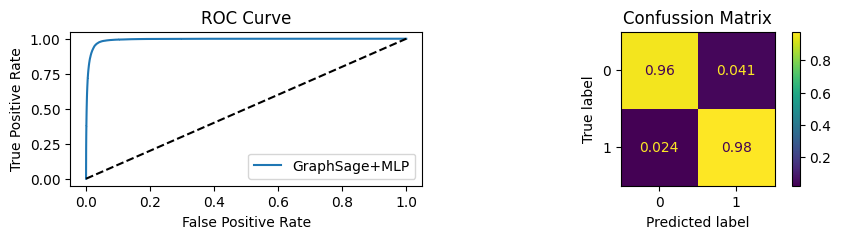

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 441: loss: 0.18577
Sensitivity (poss_acc):0.9668 Specificity (negative_acc):0.9605 accuracy:0.9637


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 442: loss: 0.18636
Sensitivity (poss_acc):0.9661 Specificity (negative_acc):0.9618 accuracy:0.9640


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 443: loss: 0.18691
Sensitivity (poss_acc):0.9663 Specificity (negative_acc):0.9615 accuracy:0.9639


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 444: loss: 0.18597
Sensitivity (poss_acc):0.9687 Specificity (negative_acc):0.9596 accuracy:0.9641


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 445: loss: 0.1864
Sensitivity (poss_acc):0.9717 Specificity (negative_acc):0.9590 accuracy:0.9653


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 446: loss: 0.18587
Sensitivity (poss_acc):0.9731 Specificity (negative_acc):0.9570 accuracy:0.9650


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 447: loss: 0.18647
Sensitivity (poss_acc):0.9645 Specificity (negative_acc):0.9621 accuracy:0.9633


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 448: loss: 0.1859
Sensitivity (poss_acc):0.9644 Specificity (negative_acc):0.9629 accuracy:0.9637


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 449: loss: 0.18523
Sensitivity (poss_acc):0.9712 Specificity (negative_acc):0.9595 accuracy:0.9653


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 450: loss: 0.18558
Sensitivity (poss_acc):0.9706 Specificity (negative_acc):0.9583 accuracy:0.9644


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 451: loss: 0.18502
Sensitivity (poss_acc):0.9689 Specificity (negative_acc):0.9594 accuracy:0.9641


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 452: loss: 0.18572
Sensitivity (poss_acc):0.9682 Specificity (negative_acc):0.9621 accuracy:0.9651


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 453: loss: 0.18526
Sensitivity (poss_acc):0.9682 Specificity (negative_acc):0.9595 accuracy:0.9638


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 454: loss: 0.18458
Sensitivity (poss_acc):0.9701 Specificity (negative_acc):0.9592 accuracy:0.9647


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 455: loss: 0.1839
Sensitivity (poss_acc):0.9736 Specificity (negative_acc):0.9558 accuracy:0.9647


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 456: loss: 0.18571
Sensitivity (poss_acc):0.9671 Specificity (negative_acc):0.9617 accuracy:0.9644


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 457: loss: 0.18385
Sensitivity (poss_acc):0.9719 Specificity (negative_acc):0.9586 accuracy:0.9653


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 458: loss: 0.18367
Sensitivity (poss_acc):0.9733 Specificity (negative_acc):0.9583 accuracy:0.9658


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 459: loss: 0.18333
Sensitivity (poss_acc):0.9727 Specificity (negative_acc):0.9586 accuracy:0.9656


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 460: loss: 0.18483
Youdens  index: 0.4715 Sensitivity: 0.9787 Specificity: 0.958


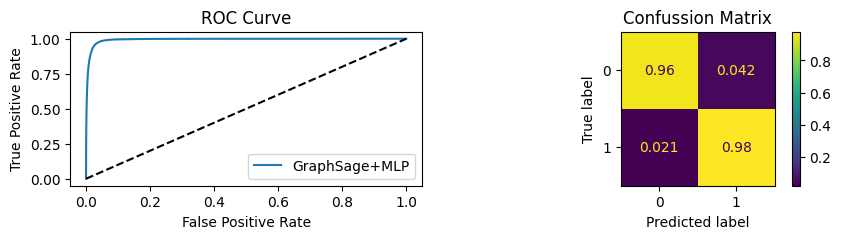

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 461: loss: 0.18353
Sensitivity (poss_acc):0.9717 Specificity (negative_acc):0.9577 accuracy:0.9647


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 462: loss: 0.18344
Sensitivity (poss_acc):0.9718 Specificity (negative_acc):0.9602 accuracy:0.9660


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 463: loss: 0.18298
Sensitivity (poss_acc):0.9690 Specificity (negative_acc):0.9613 accuracy:0.9652


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 464: loss: 0.18365
Sensitivity (poss_acc):0.9737 Specificity (negative_acc):0.9581 accuracy:0.9659


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 465: loss: 0.18268
Sensitivity (poss_acc):0.9707 Specificity (negative_acc):0.9607 accuracy:0.9657


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 466: loss: 0.18315
Sensitivity (poss_acc):0.9749 Specificity (negative_acc):0.9577 accuracy:0.9663
Replacing models: GraphSage_epoch_429.pt  link_predictor_epoch_429.pt
with: Best models at GraphSage_epoch_466.pt  link_predictor_epoch_466.pt
Saving Model in Path GraphSage_epoch_466.pt
Saving Model in Path link_predictor_epoch_466.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 467: loss: 0.18337
Sensitivity (poss_acc):0.9758 Specificity (negative_acc):0.9563 accuracy:0.9660


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 468: loss: 0.18325
Sensitivity (poss_acc):0.9735 Specificity (negative_acc):0.9579 accuracy:0.9657


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 469: loss: 0.18206
Sensitivity (poss_acc):0.9714 Specificity (negative_acc):0.9591 accuracy:0.9653


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 470: loss: 0.18238
Sensitivity (poss_acc):0.9728 Specificity (negative_acc):0.9603 accuracy:0.9666
Replacing models: GraphSage_epoch_466.pt  link_predictor_epoch_466.pt
with: Best models at GraphSage_epoch_470.pt  link_predictor_epoch_470.pt
Saving Model in Path GraphSage_epoch_470.pt
Saving Model in Path link_predictor_epoch_470.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 471: loss: 0.18358
Sensitivity (poss_acc):0.9717 Specificity (negative_acc):0.9585 accuracy:0.9651


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 472: loss: 0.182
Sensitivity (poss_acc):0.9731 Specificity (negative_acc):0.9578 accuracy:0.9654


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 473: loss: 0.18042
Sensitivity (poss_acc):0.9731 Specificity (negative_acc):0.9565 accuracy:0.9648


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 474: loss: 0.18151
Sensitivity (poss_acc):0.9708 Specificity (negative_acc):0.9590 accuracy:0.9649


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 475: loss: 0.18104
Sensitivity (poss_acc):0.9733 Specificity (negative_acc):0.9583 accuracy:0.9658


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 476: loss: 0.18099
Sensitivity (poss_acc):0.9706 Specificity (negative_acc):0.9605 accuracy:0.9656


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 477: loss: 0.18137
Sensitivity (poss_acc):0.9736 Specificity (negative_acc):0.9567 accuracy:0.9651


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 478: loss: 0.18126
Sensitivity (poss_acc):0.9709 Specificity (negative_acc):0.9597 accuracy:0.9653


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 479: loss: 0.1807
Sensitivity (poss_acc):0.9740 Specificity (negative_acc):0.9599 accuracy:0.9670
Replacing models: GraphSage_epoch_470.pt  link_predictor_epoch_470.pt
with: Best models at GraphSage_epoch_479.pt  link_predictor_epoch_479.pt
Saving Model in Path GraphSage_epoch_479.pt
Saving Model in Path link_predictor_epoch_479.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 480: loss: 0.18089
Youdens  index: 0.4555 Sensitivity: 0.9781 Specificity: 0.9591


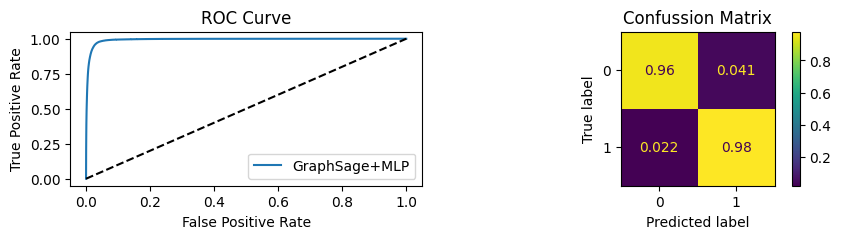

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 481: loss: 0.18051
Sensitivity (poss_acc):0.9731 Specificity (negative_acc):0.9603 accuracy:0.9667


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 482: loss: 0.18055
Sensitivity (poss_acc):0.9739 Specificity (negative_acc):0.9573 accuracy:0.9656


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 483: loss: 0.18024
Sensitivity (poss_acc):0.9720 Specificity (negative_acc):0.9594 accuracy:0.9657


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 484: loss: 0.17998
Sensitivity (poss_acc):0.9745 Specificity (negative_acc):0.9577 accuracy:0.9661


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 485: loss: 0.17946
Sensitivity (poss_acc):0.9730 Specificity (negative_acc):0.9562 accuracy:0.9646


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 486: loss: 0.18005
Sensitivity (poss_acc):0.9720 Specificity (negative_acc):0.9592 accuracy:0.9656


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 487: loss: 0.17976
Sensitivity (poss_acc):0.9693 Specificity (negative_acc):0.9622 accuracy:0.9658


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 488: loss: 0.1798
Sensitivity (poss_acc):0.9697 Specificity (negative_acc):0.9619 accuracy:0.9658


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 489: loss: 0.17916
Sensitivity (poss_acc):0.9690 Specificity (negative_acc):0.9627 accuracy:0.9659


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 490: loss: 0.17923
Sensitivity (poss_acc):0.9708 Specificity (negative_acc):0.9608 accuracy:0.9658


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 491: loss: 0.17953
Sensitivity (poss_acc):0.9694 Specificity (negative_acc):0.9616 accuracy:0.9655


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 492: loss: 0.18028
Sensitivity (poss_acc):0.9704 Specificity (negative_acc):0.9608 accuracy:0.9656


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 493: loss: 0.17902
Sensitivity (poss_acc):0.9691 Specificity (negative_acc):0.9598 accuracy:0.9644


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 494: loss: 0.17926
Sensitivity (poss_acc):0.9744 Specificity (negative_acc):0.9590 accuracy:0.9667


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 495: loss: 0.1788
Sensitivity (poss_acc):0.9694 Specificity (negative_acc):0.9621 accuracy:0.9657


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 496: loss: 0.1785
Sensitivity (poss_acc):0.9688 Specificity (negative_acc):0.9636 accuracy:0.9662


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 497: loss: 0.17811
Sensitivity (poss_acc):0.9728 Specificity (negative_acc):0.9618 accuracy:0.9673
Replacing models: GraphSage_epoch_479.pt  link_predictor_epoch_479.pt
with: Best models at GraphSage_epoch_497.pt  link_predictor_epoch_497.pt
Saving Model in Path GraphSage_epoch_497.pt
Saving Model in Path link_predictor_epoch_497.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 498: loss: 0.17799
Sensitivity (poss_acc):0.9721 Specificity (negative_acc):0.9629 accuracy:0.9675
Replacing models: GraphSage_epoch_497.pt  link_predictor_epoch_497.pt
with: Best models at GraphSage_epoch_498.pt  link_predictor_epoch_498.pt
Saving Model in Path GraphSage_epoch_498.pt
Saving Model in Path link_predictor_epoch_498.pt


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 499: loss: 0.17681
Sensitivity (poss_acc):0.9667 Specificity (negative_acc):0.9641 accuracy:0.9654
Loading best models:  GraphSage_epoch_498.pt  link_predictor_epoch_498.pt


In [15]:
train_loss                      = []
train_accuracy                  = []
show_metrics_every              = 20
best_accuracy                   = 0 
best_graphsage_model_path       = ""
best_link_predictor_model_path  = ""

for epoch in range(1,epochs):
    
    ### TRAIN ####
    loss = train(model, link_predictor,train_dataset, optimizer,device) # Get Loss
    train_loss.append(loss)
    print(f"Epoch {epoch}: loss: {round(loss, 5)}")
    
    ### EVALUATE ###
    if (epoch % 20 == 0) or (epoch ==1):
        accuracy = evaluate(model, link_predictor ,test_dataset,device=device,best_accuracy=best_accuracy,show_extra_metrics=True)
        
    else:
        accuracy = evaluate(model, link_predictor ,test_dataset,device=device,best_accuracy=best_accuracy)
    
    train_accuracy.append(accuracy)
    ### SAVE ###
    if best_accuracy < accuracy:
        if os.path.exists(best_graphsage_model_path):
            
            os.remove(best_graphsage_model_path)
            
        if os.path.exists(best_link_predictor_model_path):
            os.remove(best_link_predictor_model_path)
        print(f"Replacing models: {best_graphsage_model_path }  {best_link_predictor_model_path}")
            
        best_accuracy  = accuracy
        best_graphsage_model_path      = f"GraphSage_epoch_{epoch}.pt"
        best_link_predictor_model_path =  f"link_predictor_epoch_{epoch}.pt"
        print(f"with: Best models at {best_graphsage_model_path }  {best_link_predictor_model_path}")
        save_torch_model(model,         epoch=epoch,PATH=best_graphsage_model_path ,     optimizer=optimizer)
        save_torch_model(link_predictor,epoch=epoch,PATH=best_link_predictor_model_path, optimizer=optimizer)

        
#### Load Best Models ####

print(f"Loading best models:  {best_graphsage_model_path }  {best_link_predictor_model_path}")
checkpoint = torch.load(best_graphsage_model_path)
model.load_state_dict(checkpoint['model_state_dict'])

checkpoint = torch.load(best_link_predictor_model_path)
link_predictor.load_state_dict(checkpoint['model_state_dict'])

del checkpoint

    
        

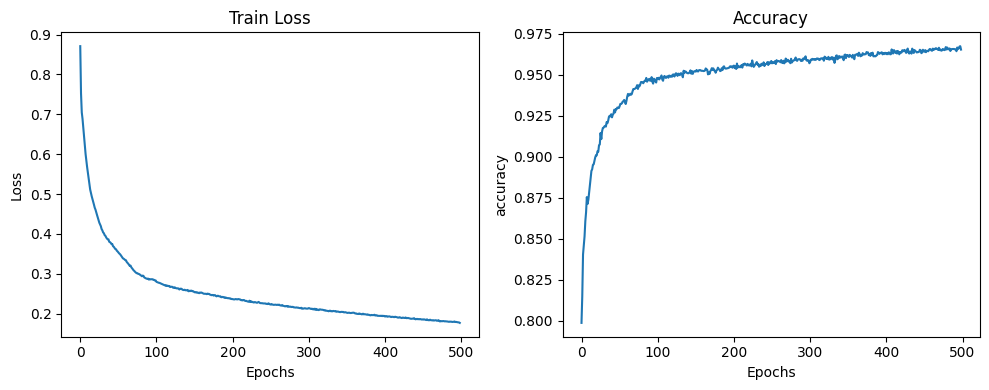

In [22]:
fig, ax = plt.subplots(1, 2,figsize=(10,4))

ax[0].set_title("Train Loss")
ax[0].plot(train_loss)
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Epochs")

ax[1].set_title("Accuracy")
ax[1].plot(train_accuracy)
ax[1].set_ylabel("accuracy")
ax[1].set_xlabel("Epochs")
fig.tight_layout()
plt.show()

## Evaluating the best Model:
For the Last Step lets evaluate how our model perform when different percentages of PPIs per organism are given!

Evaluating Model with 1.0% of PPI's
 1719 Positive Protein Interactions were used to Embed a graph with 171928 ppi's
 636 Positive Protein Interactions were used to Embed a graph with 63612 ppi's
 280 Positive Protein Interactions were used to Embed a graph with 28012 ppi's
 817 Positive Protein Interactions were used to Embed a graph with 81758 ppi's
Youdens  index: 0.0000 Sensitivity: 0.5599 Specificity: 0.8714


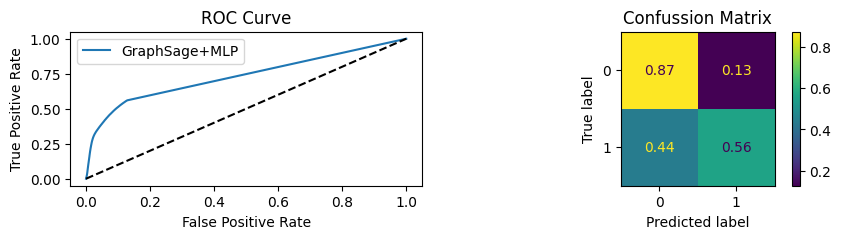


Evaluating Model with 10.0% of PPI's
 17192 Positive Protein Interactions were used to Embed a graph with 171928 ppi's
 6361 Positive Protein Interactions were used to Embed a graph with 63612 ppi's
 2801 Positive Protein Interactions were used to Embed a graph with 28012 ppi's
 8175 Positive Protein Interactions were used to Embed a graph with 81758 ppi's
Youdens  index: 0.0127 Sensitivity: 0.8587 Specificity: 0.9084


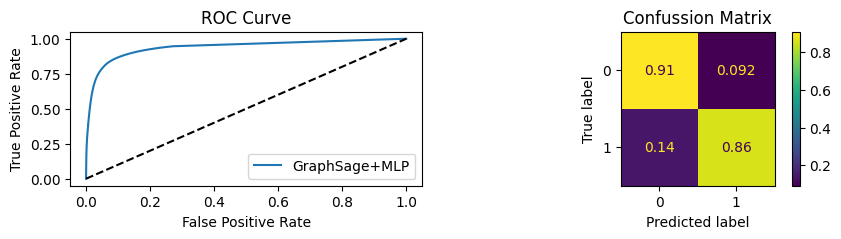


Evaluating Model with 20.0% of PPI's
 34385 Positive Protein Interactions were used to Embed a graph with 171928 ppi's
 12722 Positive Protein Interactions were used to Embed a graph with 63612 ppi's
 5602 Positive Protein Interactions were used to Embed a graph with 28012 ppi's
 16351 Positive Protein Interactions were used to Embed a graph with 81758 ppi's
Youdens  index: 0.0940 Sensitivity: 0.9161 Specificity: 0.9268


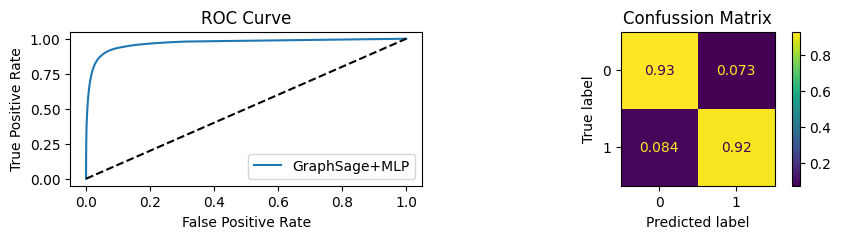


Evaluating Model with 30.0% of PPI's
 51578 Positive Protein Interactions were used to Embed a graph with 171928 ppi's
 19083 Positive Protein Interactions were used to Embed a graph with 63612 ppi's
 8403 Positive Protein Interactions were used to Embed a graph with 28012 ppi's
 24527 Positive Protein Interactions were used to Embed a graph with 81758 ppi's
Youdens  index: 0.2599 Sensitivity: 0.9338 Specificity: 0.9423


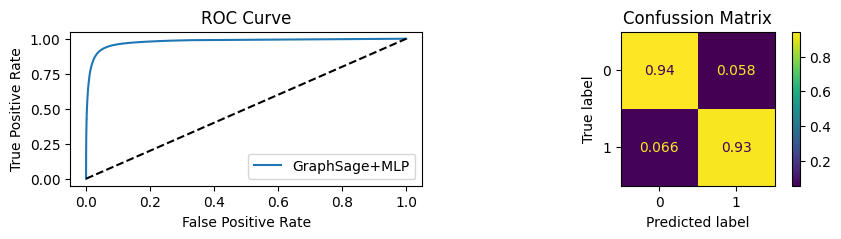


Evaluating Model with 40.0% of PPI's
 68771 Positive Protein Interactions were used to Embed a graph with 171928 ppi's
 25444 Positive Protein Interactions were used to Embed a graph with 63612 ppi's
 11204 Positive Protein Interactions were used to Embed a graph with 28012 ppi's
 32703 Positive Protein Interactions were used to Embed a graph with 81758 ppi's
Youdens  index: 0.3409 Sensitivity: 0.9491 Specificity: 0.9497


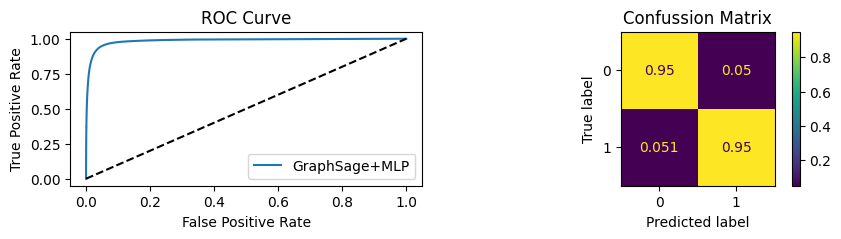


Evaluating Model with 50.0% of PPI's
 85964 Positive Protein Interactions were used to Embed a graph with 171928 ppi's
 31806 Positive Protein Interactions were used to Embed a graph with 63612 ppi's
 14006 Positive Protein Interactions were used to Embed a graph with 28012 ppi's
 40879 Positive Protein Interactions were used to Embed a graph with 81758 ppi's
Youdens  index: 0.3092 Sensitivity: 0.9623 Specificity: 0.9501


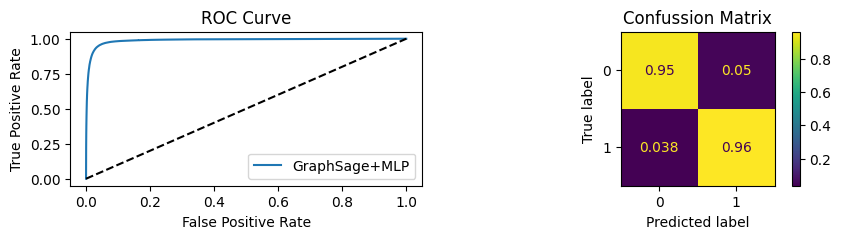


Evaluating Model with 60.0% of PPI's
 103156 Positive Protein Interactions were used to Embed a graph with 171928 ppi's
 38167 Positive Protein Interactions were used to Embed a graph with 63612 ppi's
 16807 Positive Protein Interactions were used to Embed a graph with 28012 ppi's
 49054 Positive Protein Interactions were used to Embed a graph with 81758 ppi's
Youdens  index: 0.3714 Sensitivity: 0.9672 Specificity: 0.9546


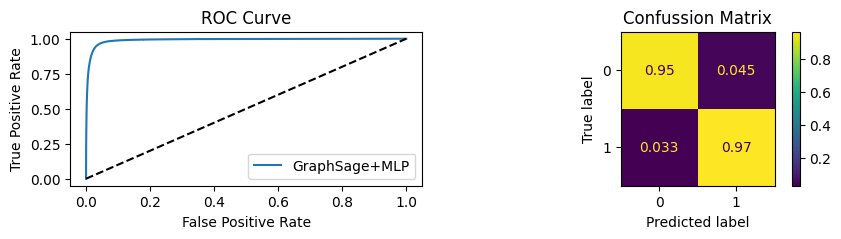

In [23]:
for i in [0.01, 0.1,0.2,0.3,0.4,0.5,0.6]:
    print(f"Evaluating Model with {i*100}% of PPI's")
    evaluate(model, link_predictor ,test_dataset,device=device,ppi_=i,verbose=True,show_extra_metrics=True)
    print()
    

# Comparison with a standard MLP
One can argue that our model performs well due to our ProteinBERT embeddigs, however, we argue it works both beacause of our embeddings and GNN's to make our point we will train a standard MLP and compare it agianst our models

In [52]:
epochs        = 21
dropout       = 0.7
num_layers    = 3
learning_rate = 1e-4
node_emb_dim  = 1024  # bert embedding size 
hidden_dim    = 512
device        = "cpu"

model_b            = None
link_predictor_b   = LinkPredictorMLP(in_channels      = node_emb_dim , 
                                    hidden_channels    = hidden_dim,
                                    out_channels       = 1,
                                    n_layers           = num_layers , 
                                    dropout_probabilty = dropout).to(device) # the MLP that takes embeddings of a pair of nodes and predicts the existence of an edge between them
optimizer      = torch.optim.Adam(link_predictor.parameters() , lr=learning_rate)

print(model_b )
print(link_predictor_b)
print(f"Models Loaded to {device}")

None
LinkPredictorMLP(
  (mlp_layers): ModuleList(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=1, bias=True)
  )
)
Models Loaded to cpu


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 1: loss: 1.38648
Youdens  index: 0.4993 Sensitivity: 0.2589 Specificity: 0.7475


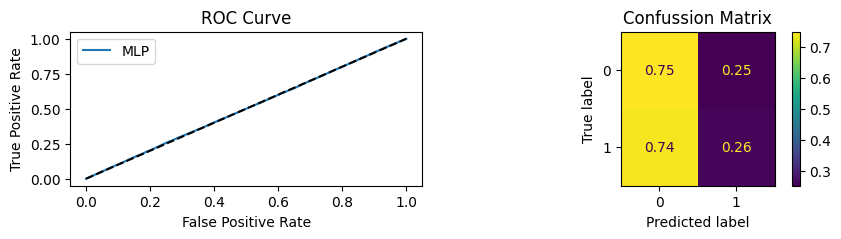

  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 2: loss: 1.38648
Sensitivity (poss_acc):0.2048 Specificity (negative_acc):0.7938 accuracy:0.4993


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 3: loss: 1.38647
Sensitivity (poss_acc):0.2006 Specificity (negative_acc):0.7915 accuracy:0.4960


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 4: loss: 1.38648
Sensitivity (poss_acc):0.2057 Specificity (negative_acc):0.7922 accuracy:0.4990


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 5: loss: 1.38647
Sensitivity (poss_acc):0.2055 Specificity (negative_acc):0.7937 accuracy:0.4996


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 6: loss: 1.38647
Sensitivity (poss_acc):0.2056 Specificity (negative_acc):0.7902 accuracy:0.4979


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 7: loss: 1.38647
Sensitivity (poss_acc):0.2050 Specificity (negative_acc):0.7932 accuracy:0.4991


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 8: loss: 1.38648
Sensitivity (poss_acc):0.2045 Specificity (negative_acc):0.7919 accuracy:0.4982


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 9: loss: 1.38647
Sensitivity (poss_acc):0.2036 Specificity (negative_acc):0.7914 accuracy:0.4975


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 10: loss: 1.38646
Sensitivity (poss_acc):0.2088 Specificity (negative_acc):0.7923 accuracy:0.5006


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 11: loss: 1.38648
Sensitivity (poss_acc):0.2108 Specificity (negative_acc):0.7921 accuracy:0.5014


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 12: loss: 1.38648
Sensitivity (poss_acc):0.2043 Specificity (negative_acc):0.7922 accuracy:0.4982


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 13: loss: 1.38648
Sensitivity (poss_acc):0.2100 Specificity (negative_acc):0.7908 accuracy:0.5004


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 14: loss: 1.38647
Sensitivity (poss_acc):0.2121 Specificity (negative_acc):0.7910 accuracy:0.5015


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 15: loss: 1.38647
Sensitivity (poss_acc):0.2108 Specificity (negative_acc):0.7935 accuracy:0.5021


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 16: loss: 1.38648
Sensitivity (poss_acc):0.2038 Specificity (negative_acc):0.7929 accuracy:0.4983


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 17: loss: 1.38649
Sensitivity (poss_acc):0.2115 Specificity (negative_acc):0.7925 accuracy:0.5020


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 18: loss: 1.38648
Sensitivity (poss_acc):0.2050 Specificity (negative_acc):0.7919 accuracy:0.4985


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 19: loss: 1.38647
Sensitivity (poss_acc):0.2022 Specificity (negative_acc):0.7915 accuracy:0.4969


  0%|          | 0/65 [00:00<?, ?it/s]

Epoch 20: loss: 1.38648
Youdens  index: 0.4967 Sensitivity: 0.4517 Specificity: 0.5537


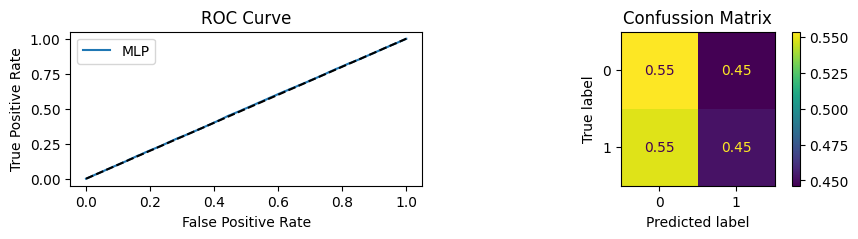

In [53]:
train_loss_b                      = []
train_accuracy_b                  = []
show_metrics_every_b              = 20
best_accuracy_b                   = 0 
best_graphsage_model_path_b       = ""
best_link_predictor_model_path_b  = ""

for epoch in range(1,epochs):
    
    ### TRAIN ####
    loss = train(model_b, link_predictor_b,train_dataset, optimizer,device) # Get Loss
    train_loss.append(loss)
    print(f"Epoch {epoch}: loss: {round(loss, 5)}")
    
    ### EVALUATE ###
    if (epoch % 20 == 0) or (epoch ==1):
        accuracy = evaluate(model_b, link_predictor_b ,test_dataset,device=device,best_accuracy=best_accuracy,show_extra_metrics=True)
        
    else:
        accuracy = evaluate(model_b, link_predictor_b ,test_dataset,device=device,best_accuracy=best_accuracy)
    
    train_accuracy.append(accuracy)
    ### SAVE ###
    if best_accuracy < accuracy:
        if os.path.exists(best_graphsage_model_path):
            
            os.remove(best_graphsage_model_path)
            
        if os.path.exists(best_link_predictor_model_path):
            os.remove(best_link_predictor_model_path)
        print(f"Replacing models: {best_graphsage_model_path }  {best_link_predictor_model_path}")
            
        best_accuracy  = accuracy
        best_link_predictor_model_path_b =  f"link_predictor_mlp_epoch_{epoch}.pt"
        print(f"with: Best models at {best_link_predictor_model_path_b}")
        save_torch_model(link_predictor_b,epoch=epoch,PATH=best_link_predictor_model_path_b, optimizer=optimizer)

        
#### Load Best Models ####


    
        

In [ ]:
# Explain how MLP did not perform well but MLP +  graphsage performed really well

## Referneces

[1] Takeshi Kojima, Shixiang Shane Gu, Machel Reid, Yutaka Matsuo, and Yusuke Iwasawa. Large
language models are zero-shot reasoners. arXiv preprint arXiv:2205.11916, 2022.

[2] Jacob Devlin, Ming-Wei Chang, Kenton Lee, and Kristina Toutanova. Bert: Pre-training of
deep bidirectional transformers for language understanding. arXiv preprint arXiv:1810.04805,
2018.

[3] Ivano Lauriola, Alberto Lavelli, and Fabio Aiolli. An introduction to deep learning in natural
language processing: Models, techniques, and tools. Neurocomputing, 470:443–456, 2022

[4] Shijie Chen, Yu Zhang, and Qiang Yang. Multi-task learning in natural language processing:
An overview. arXiv preprint arXiv:2109.09138, 2021

[5] Brandes, N., Ofer, D., Peleg, Y., Rappoport, N., & Linial, M. (2022). Proteinbert: A uni-
versal deep-learning model of protein sequence and function. Bioinformatics, 38(8), 2102–2110.
https://doi.org/10.1093/bioinformatics/btac020 

[6] Szklarczyk, D., Gable, A. L., Lyon, D., Junge, A., Wyder, S., Huerta-Cepas, J., Simonovic, M., Doncheva, N.
T., Morris, J. H., Bork, P., Jensen, L. J., & Mering, C. (2018). String V11: Protein–protein association networks
with increased coverage, supporting functional discovery in genome-wide experimental datasets. Nucleic Acids
Research, 47(D1). https://doi.org/10.1093/nar/gky1131

[7] Hu, W., Fey, M., Zitnik, M., Dong, Y., Ren, H., Liu, B., Catasta, M., & Leskovec, J. (2020). Open Graph
Benchmark: Datasets for Machine Learning on Graphs. arXiv. https://doi.org/10.48550/ARXIV.2005.00687

[8] Brandes, N., Ofer, D., Peleg, Y., Rappoport, N., & Linial, M. (2022). Proteinbert: A uni-
versal deep-learning model of protein sequence and function. Bioinformatics, 38(8), 2102–2110.
https://doi.org/10.1093/bioinformatics/btac020

[9] Hamilton, W. L., Ying, R., & Leskovec, J. (2017). Inductive Representation Learning on Large Graphs.
arXiv. https://doi.org/https://doi.org/10.48550/arXiv.1706.02216
3
